# Project1

### Todo
Jędrzej
1. Morphological operations:
    to denoise the imgage
    to connect the disconnected components in lines,
2. Think of another preprocessing techniques maybe

    
Mateusz
1. Line detection , Hough_lines , Hough_lines_p
2. contour detection - Canny detector, 
3. Lines detection connected with contour detection

In [238]:
''''imports '''
import numpy as np


import cv2
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import datetime
import glob
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde


### Data reading/creating

In [239]:


def set_axis(x, no_labels = 7)->tuple[np.array, np.array]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels





In [240]:
path_out = 'mateusz\\'
files = glob.glob(path_out+"*")
files.sort()




In [241]:
dx= 5.106500953873407 
dt= 0.0016


data_1 = []
data_2 = []
first_filename_1 = files[0]
first_filename_2 = files[6]
for file in files[:6]:
   data_1.append(np.load(file))
for file in files[6:]:
    data_2.append(np.load(file))


data_1 = np.concatenate(data_1)
data_2 = np.concatenate(data_2)
time_start_1 = datetime.datetime.strptime('2024-05-07 ' + first_filename_1.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
time_start_2 = datetime.datetime.strptime('2024-05-07 ' + first_filename_2.split("\\")[-1].split(".")[0], "%Y-%m-%d %H%M%S")

index_1 = pd.date_range(start=time_start_1, periods=len(data_1), freq=f'{dt}s')
index_2 = pd.date_range(start=time_start_2, periods=len(data_1), freq=f'{dt}s')


columns_1 = np.arange(len(data_1[0])) * dx
columns_2 = np.arange(len(data_2[0])) * dx


df_1 = pd.DataFrame(data=data_1, index=index_1, columns=columns_1)
df_2 = pd.DataFrame(data=data_2, index=index_2, columns=columns_2)




### Data preprocessing functions

In [242]:
'''converting to 0-255 int to be able to use opencv functions for image preprocessing'''
def convert_to_img_format(df,ret_dataframe=True):
    data = df.to_numpy()
    data = np.floor(data *255)
    if ret_dataframe:
        return pd.DataFrame(data, index=df.index, columns=df.columns)
    else:
        return data

In [268]:
'''downsampling since the resolution of the image is 37500 x 52 so it could be difficult for the line detection to work, the line can be scattered
vertically  ,probably some kind
of the time dimension downsampling shall be performed'''




def downsampling_time_mean(df, window_size=10, ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute mean
    downsampled_data = trimmed_data.reshape(-1, window_size, data.shape[1]).mean(axis=1)


    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data


def downsampling_time_median(df, window_size=10, ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data = np.median(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    
def downsampling_time_max(df,window_size=10,ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data = np.max(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    
def downsampling_time_max_mean(df,window_size=10,ret_dataframe=True):
    data = df.to_numpy()

    # Ensure the number of rows is divisible by the window size
    trimmed_size = (data.shape[0] // window_size) * window_size
    trimmed_data = data[:trimmed_size]  # Trim excess rows if necessary

    # Reshape and compute median
    downsampled_data_max = np.max(trimmed_data.reshape(-1, window_size, data.shape[1]), axis=1)
    downsampled_data_mean = trimmed_data.reshape(-1, window_size, data.shape[1]).mean(axis=1)
    downsampled_data = downsampled_data_max - downsampled_data_mean

    if ret_dataframe:
        # Create a new index
        new_index = df.index[:trimmed_size:window_size]  # Take every `window_size` step
        return pd.DataFrame(downsampled_data, index=new_index, columns=df.columns)
    else:
        return downsampled_data
    


In [244]:
def thresholding_otsu_function(df, ret_dataframe = True):
        data = df.to_numpy()
        data= data.astype(np.uint8)
        thresh, image = cv2.threshold(
        data, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)
        if ret_dataframe:
                return pd.DataFrame(image,index = df.index, columns = df.columns)
        else:
                return image
        
def thresholding_adaptive_function(df,blocksize=101,constant=2,ret_dataframe = True):
        data = df.to_numpy()
        data= data.astype(np.uint8)
        image = cv2.adaptiveThreshold(
        data, 255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,blocksize,constant
)
        if ret_dataframe:
                return pd.DataFrame(image,index = df.index, columns = df.columns)
        else:
                return image
        
def thresholding_adaptive_gaussian_function(df,blocksize=101,constant=2,ret_dataframe = True):
        data = df.to_numpy()
        data= data.astype(np.uint8)
        image = cv2.adaptiveThreshold(
        data, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,blocksize,constant
)
        if ret_dataframe:
                return pd.DataFrame(image,index = df.index, columns = df.columns)
        else:
                return image



In [245]:
'''name being the blurring function but may also be a vertical aggregation function bcs when the kernel is for example (11,1) then it
is just an aggregation of 11 cells , 5 above given cell and 5 below '''
def blurring_function(df,kernel_size=5, gaussian = True,ret_dataframe = True):
    print(type(df))
    if gaussian:
        data_blurred = cv2.GaussianBlur(df.to_numpy(),kernel_size,0)
    else:
        kernel = np.ones((kernel_size[0],kernel_size[1]))*(1/(kernel_size[0]*kernel_size[1]))
        data_blurred = cv2.filter2D(src=df.to_numpy(),kernel=kernel,ddepth=-1)
    if ret_dataframe:
        return pd.DataFrame(data_blurred, index=df.index, columns=df.columns)
    else:
        return data_blurred


In [246]:



def basic_preprocessing(df, minmax=False,ret_dataframe=False):
    """
    Preprocesses a DataFrame by centering, taking absolute values,
    clipping outliers, and optionally applying min-max scaling.

    Parameters:
        df (pd.DataFrame): Input DataFrame to preprocess.
        minmax (bool): If True, applies min-max scaling to the data.

    Returns:
        pd.DataFrame: A new DataFrame with altered data, preserving the original index and columns.
    """
    # Make a copy of the input DataFrame to avoid modifying it
    new_df = df.copy()
    
    # Center the data by subtracting the mean
    new_df -= new_df.mean()
    
    # Take the absolute value
    new_df = np.abs(new_df)
    
    # Clip outliers at the 3rd and 99th percentiles
    low, high = np.percentile(new_df.values, [3, 99])  # Use .values to apply percentiles to the entire data
    new_df = np.clip(new_df, low, high)
    
    # Apply min-max scaling if specified
    if minmax:
        new_df = (new_df - low) / (high - low)
        new_df[new_df < 0] = 0  # Ensure lower values are clipped correctly

    # Return as DataFrame to preserve structure
    if ret_dataframe:
        return pd.DataFrame(new_df, index=df.index, columns=df.columns)
    else:
        numpy_array = new_df.to_numpy()
        return numpy_array

### Morphologic operations

### Plotting functions

In [247]:



def plot_continuous_histogram(data, number_of_kernels=50):
    """
    Plots a continuous histogram (distribution) of values from a 2D NumPy array
    with customizable bin width and zoom range.

    Parameters:
        data (numpy.ndarray): 2D NumPy array of float64 values.
        bin_width (float): Desired width of bins for the histogram. Defaults to auto.
        zoom_range (tuple): Optional (min, max) range to zoom in on x-axis.
    """
    if not isinstance(data, np.ndarray):
        raise TypeError("Input data must be a NumPy array.")
    if data.ndim != 2:
        raise ValueError("Input data must be a 2D NumPy array.")
    
    # Flatten the 2D array into 1D
    flattened_data = data.flatten()
    
    # Remove NaN or infinite values, if any
    flattened_data = flattened_data[np.isfinite(flattened_data)]
    
    # Optionally zoom in on a specific range
    
    # Compute the kernel density estimate for smoother distribution
    kde = gaussian_kde(flattened_data)
    
    # Determine x-axis range and binning
    min_val, max_val = flattened_data.min(), flattened_data.max()
    x_vals = np.linspace(min_val, max_val, number_of_kernels)
    y_vals = kde(x_vals)
    
    # Adjust bin width
    
    
    # Plot the distribution
    plt.figure(figsize=(8, 6))
    plt.plot(x_vals, y_vals, label='Data density estimation', color='blue')
    #plt.hist(flattened_data, bins=bins, density=True, alpha=0.5, color='orange', label='Histogram')
    plt.title('Continuous Histogram of 2D Array Values')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

In [248]:
'''the default plotting function'''
def plotting_function(df,to_preprocess =False):
        fig = plt.figure(figsize=(12,16))
        ax = plt.axes()

        new_df = df.copy()
        if to_preprocess:
                new_df = basic_preprocessing(df,minmax=False,ret_dataframe=True)

        low, high = np.percentile(new_df, [3, 99]) 
        norm = Normalize(vmin=low, vmax=high, clip=True)
        
        # This is an example transformation and should be converted to the proper algorithm
        


        im = ax.imshow(df,interpolation='none',aspect='auto',norm=norm)
        plt.ylabel('time')
        plt.xlabel('space [m]')

        cax = fig.add_axes([ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height])
        plt.colorbar(im, cax=cax)
        x_positions, x_labels = set_axis(df.columns)
        ax.set_xticks(x_positions, np.round(x_labels))
        y_positions, y_labels = set_axis(new_df.index.time)
        ax.set_yticks(y_positions, y_labels)
        plt.show()
 
    

# Tests

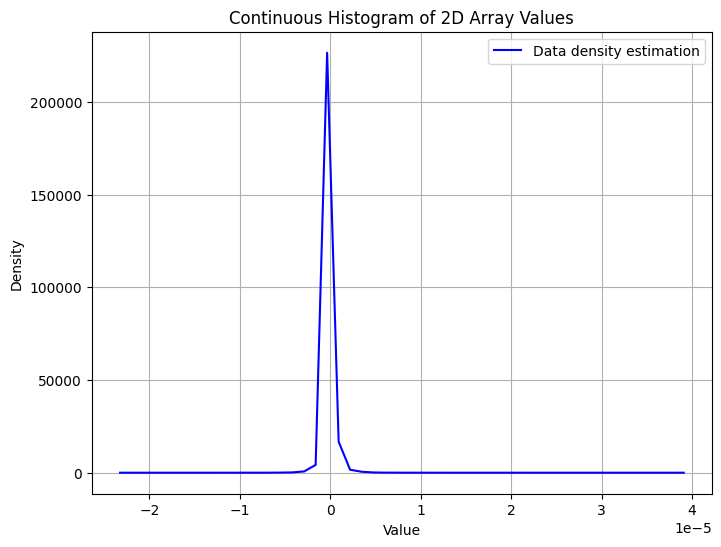

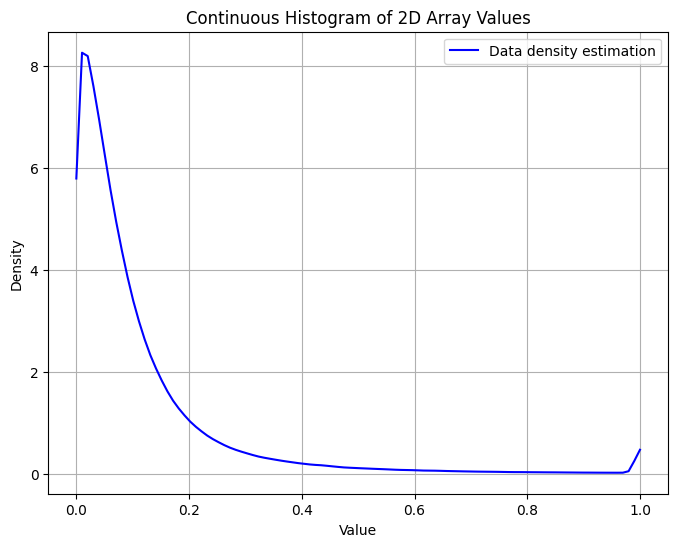

In [ ]:
'''estimating the distribution of the data'''
''''comparison of the data distirbution before basic preprocessing and after'''
plot_continuous_histogram(data_1)
'''after preprocessing'''
data_1_preprocessed = basic_preprocessing(df_1,minmax=True,ret_dataframe=False)
plot_continuous_histogram(data_1_preprocessed,number_of_kernels=100)


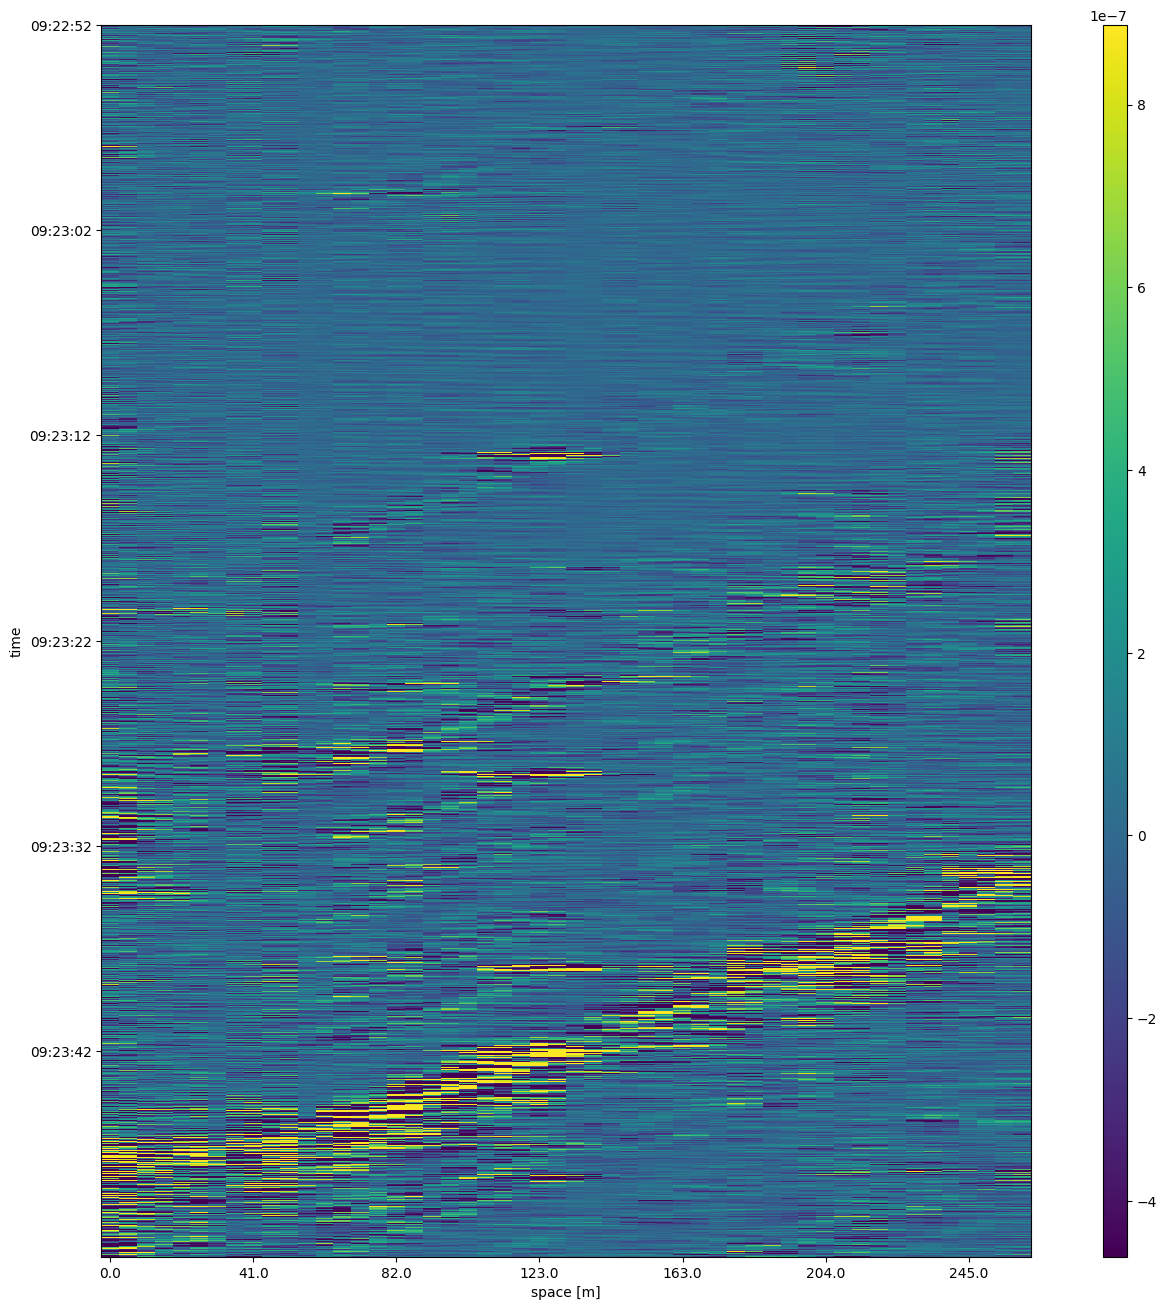

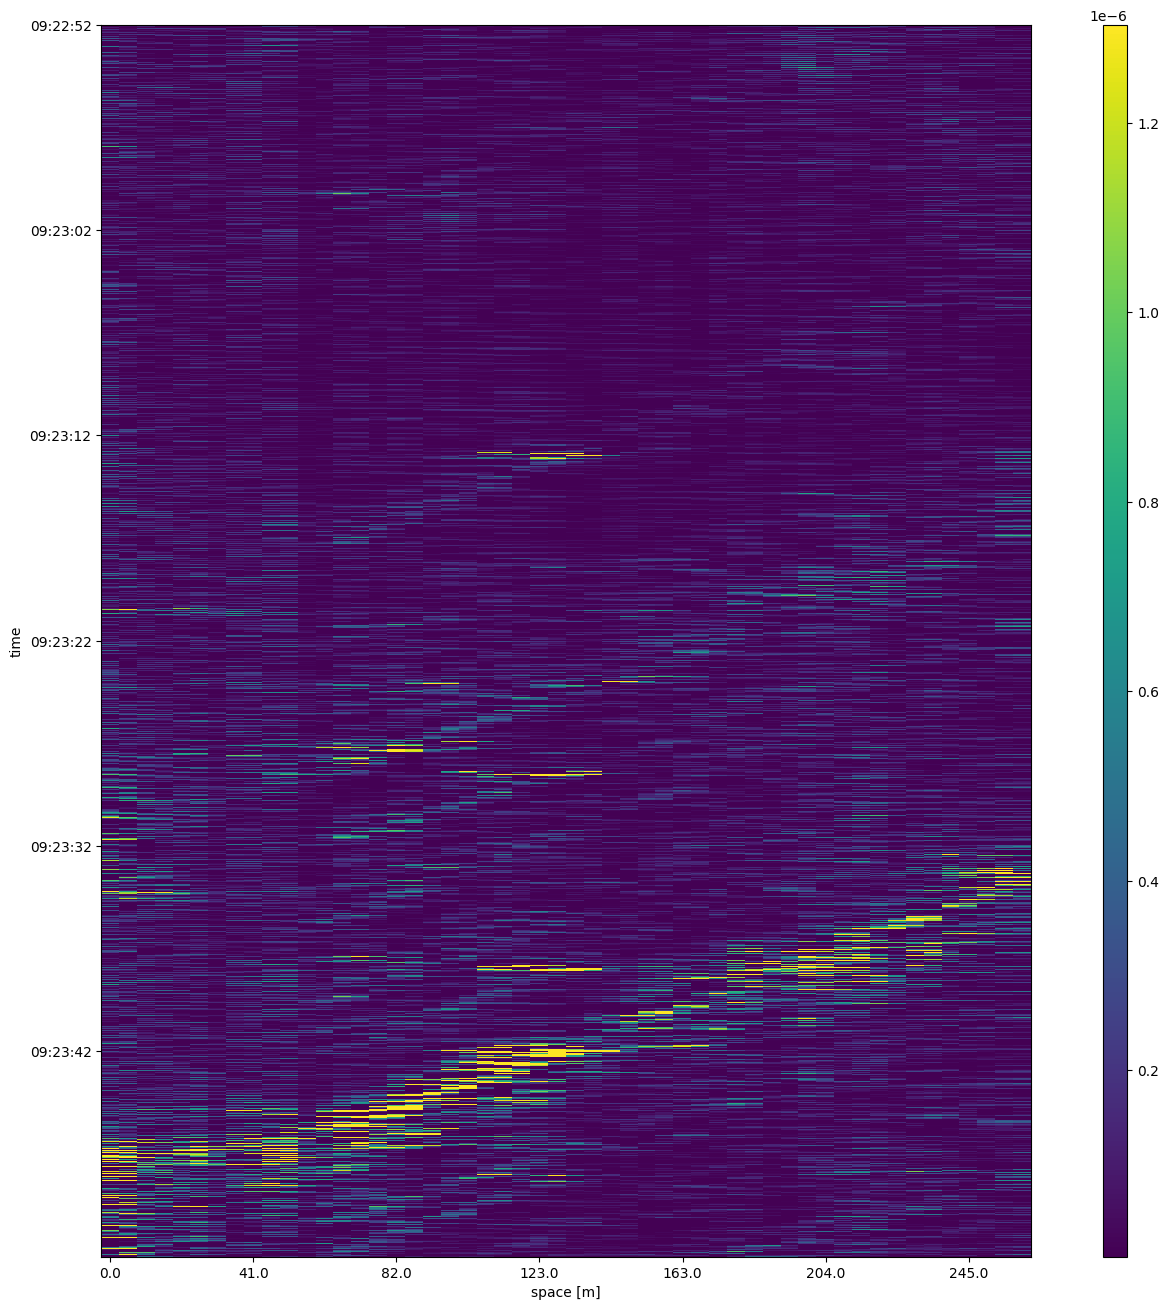

In [250]:
'''comparison of unpreprocessed with the basic preprocessing of the image'''
plotting_function(df_1,to_preprocess=False)  
plotting_function(df_1,to_preprocess=True)


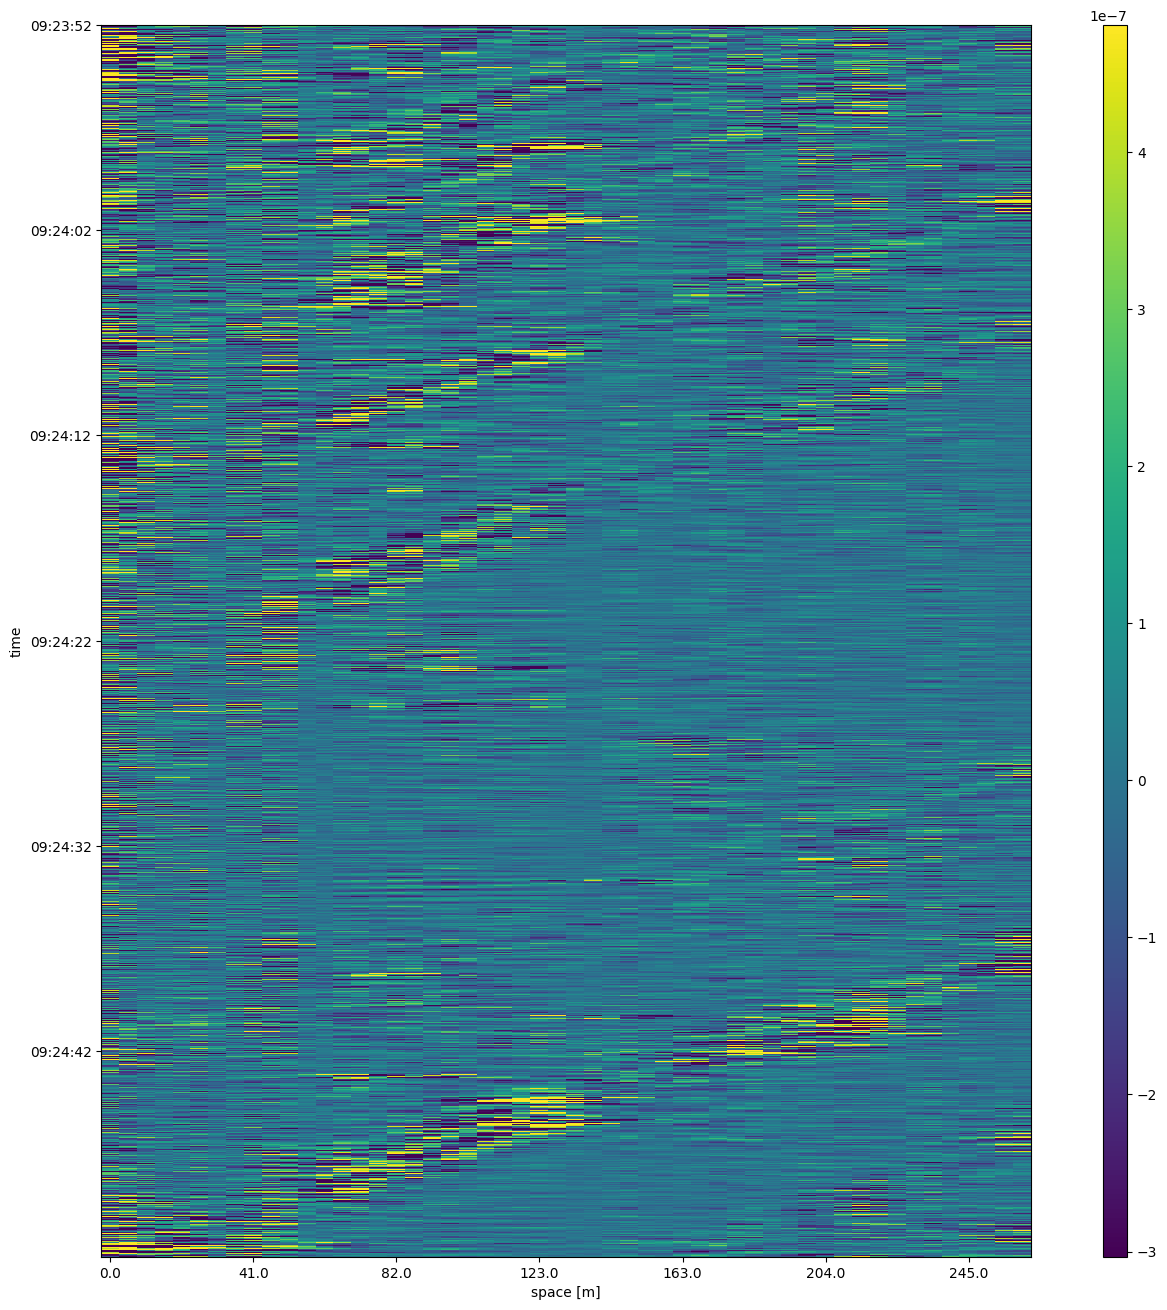

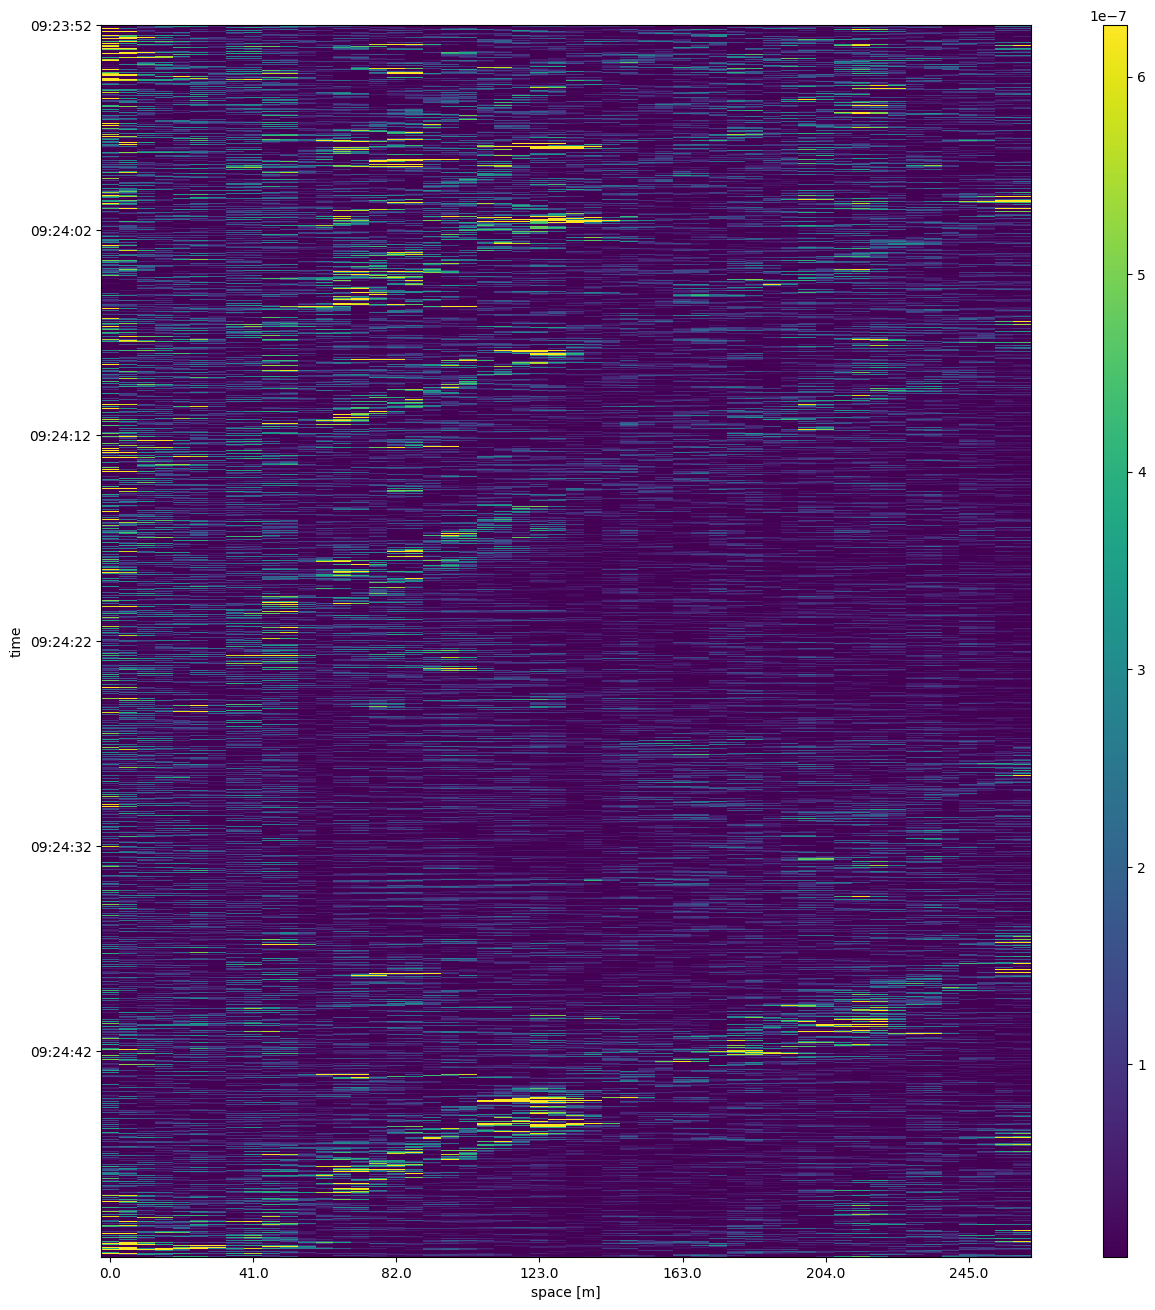

In [251]:
'''the 'image' before and after the basic preprocessing'''
plotting_function(df_2,to_preprocess=False)
plotting_function(df_2 ,to_preprocess=True)

<class 'pandas.core.frame.DataFrame'>


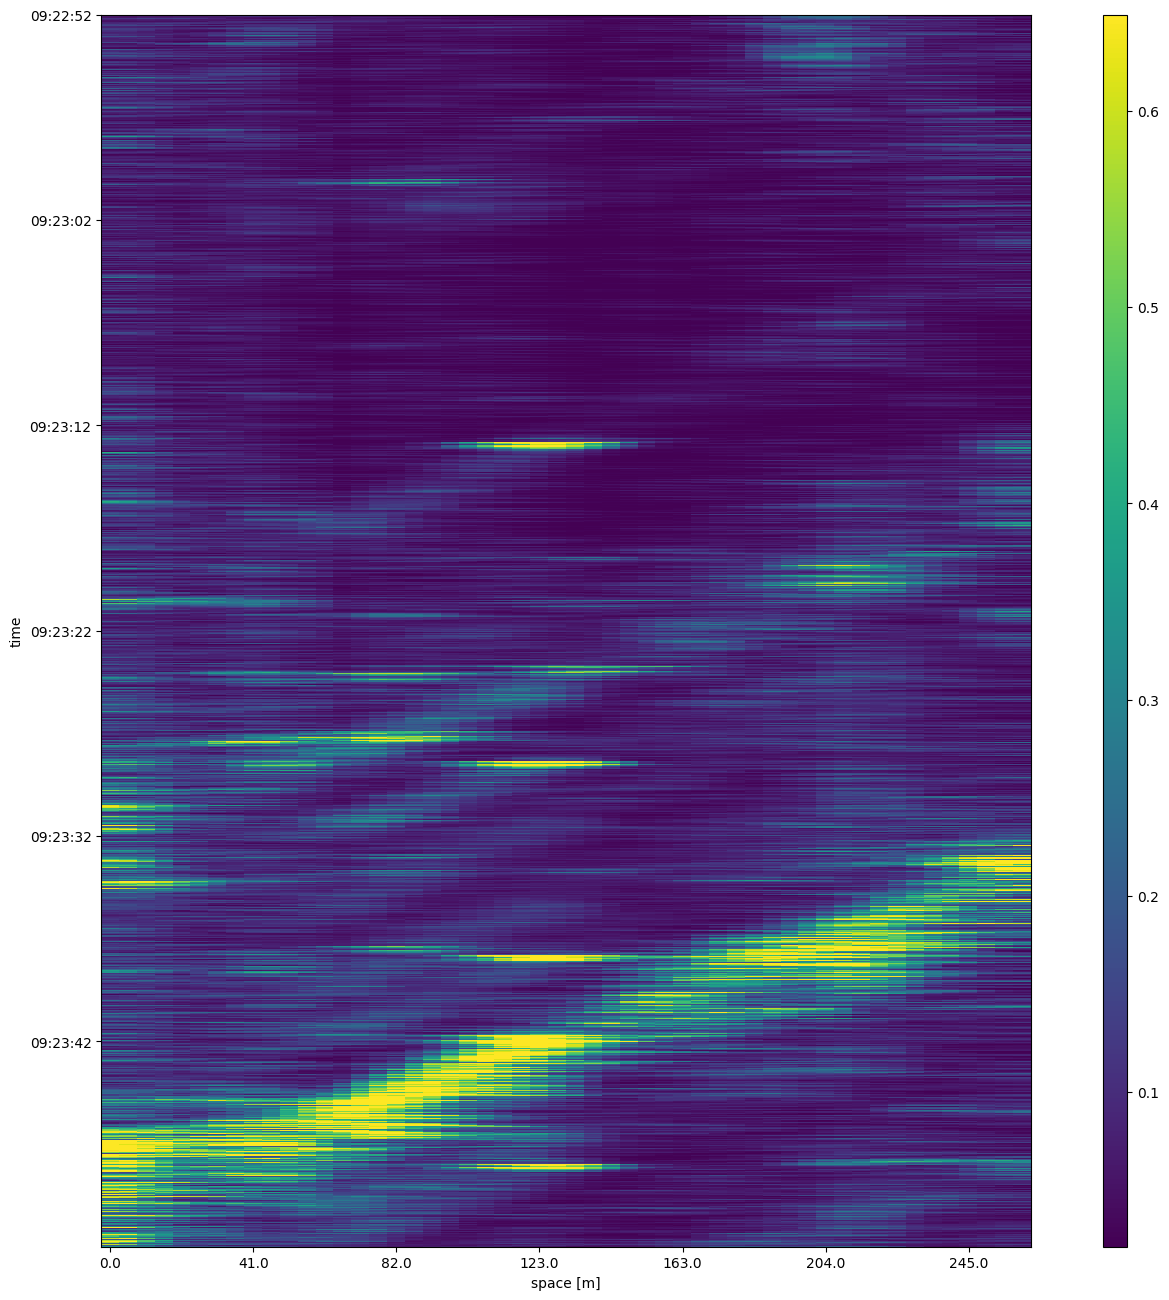

<class 'pandas.core.frame.DataFrame'>


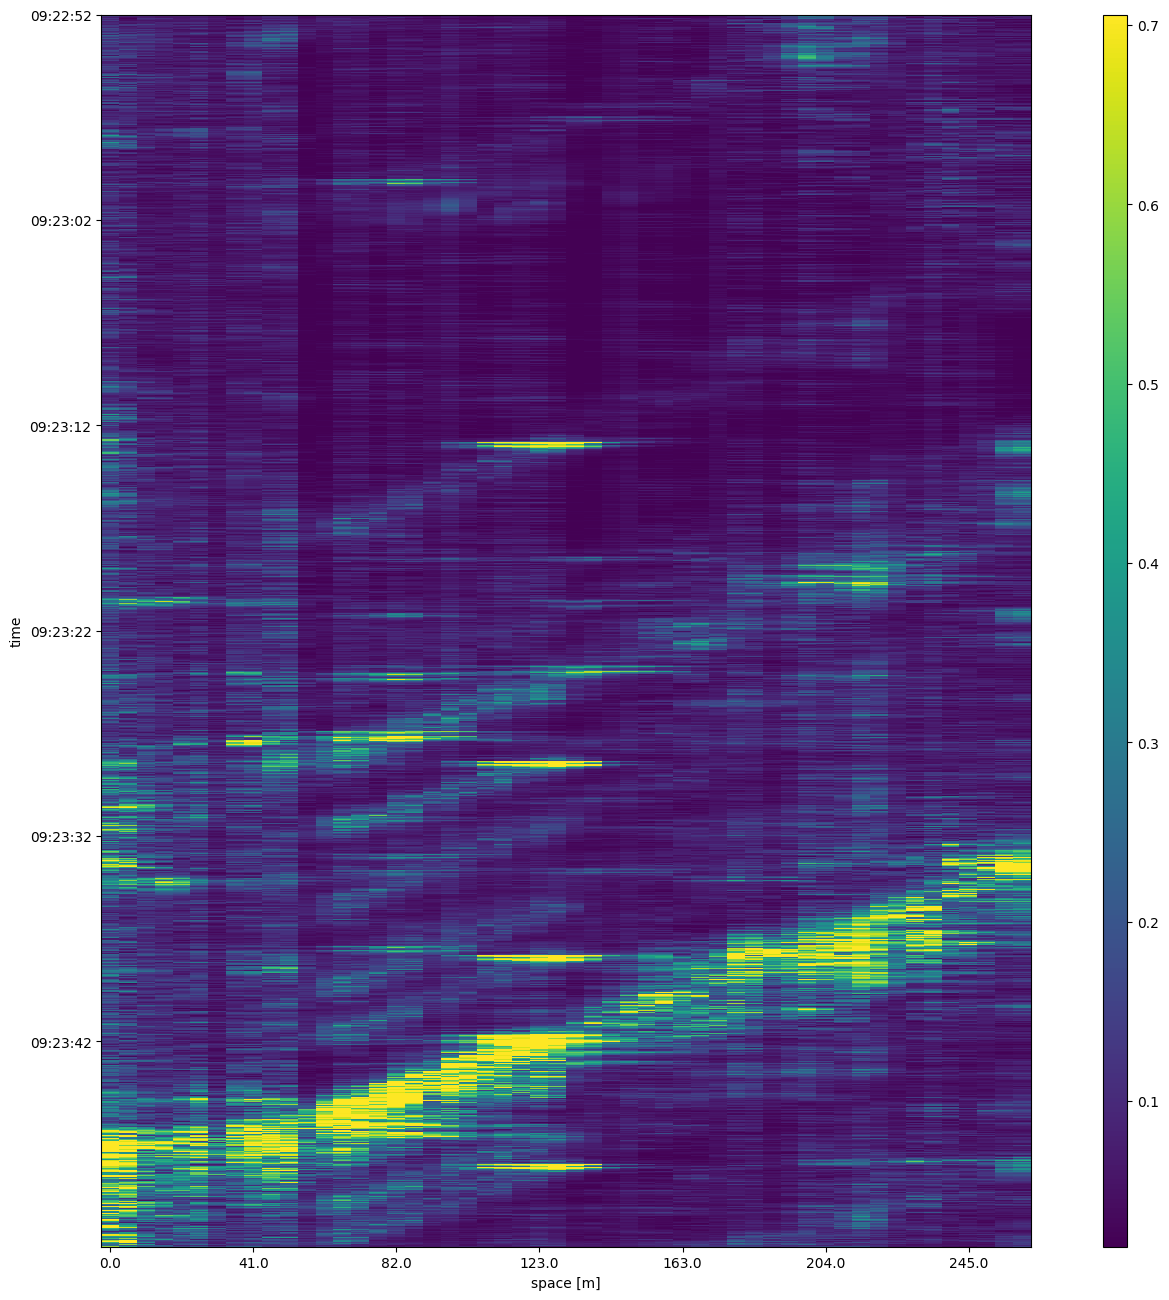

<class 'pandas.core.frame.DataFrame'>


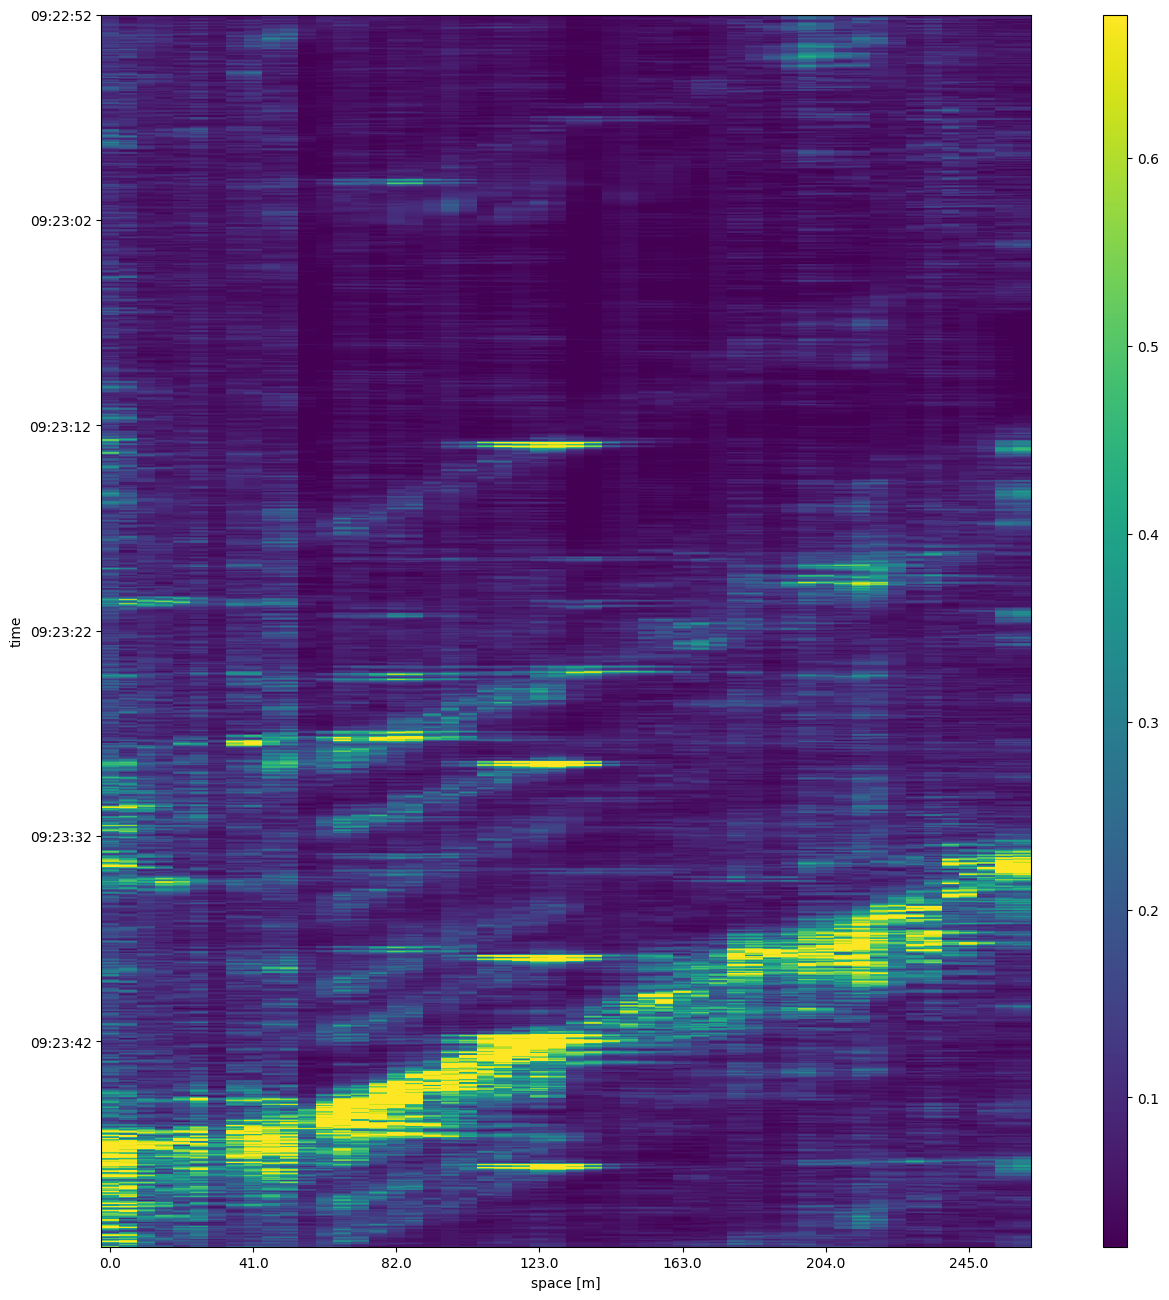

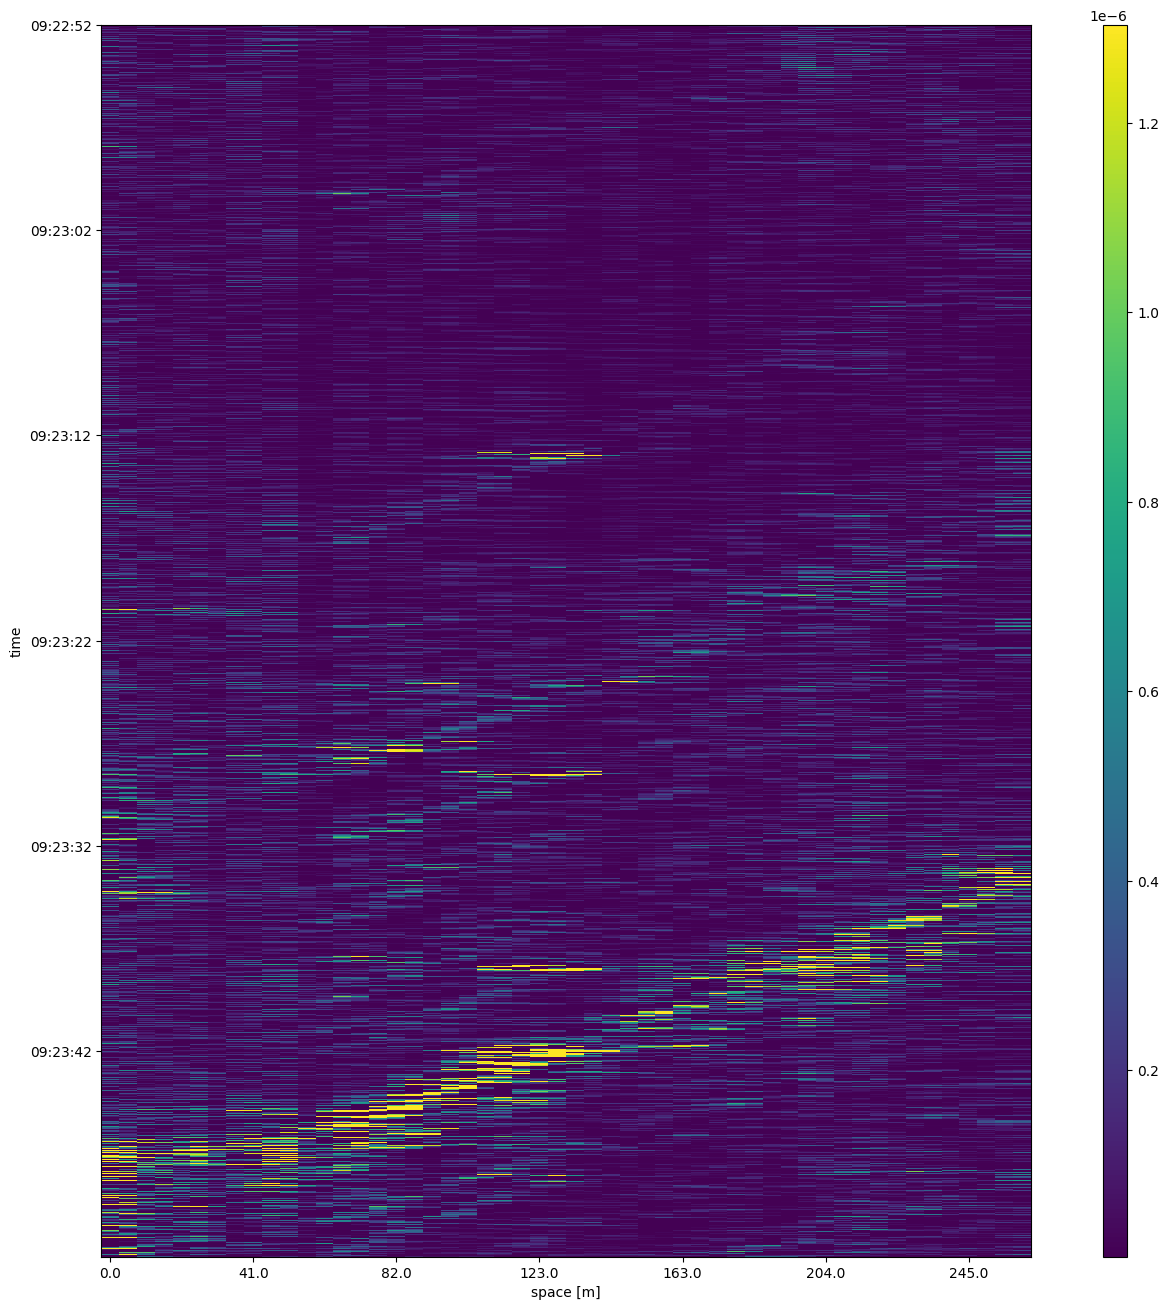

In [261]:
'''checking out other preprocessing methods'''

data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it seem to have worsen the image'''
data_1_blurred = blurring_function(data_1_preprocessed,(5,5),False,True)
plotting_function(data_1_blurred,to_preprocess=False)
'''here for each pixel the mean taken with 12 vertical neighbours to the top of it and 12 vertical neighbours to the bottom, seem to make sense '''
data_2_blurred = blurring_function(data_1_preprocessed,(25,1),False,True)
plotting_function(data_2_blurred,to_preprocess=False)
'''here even with bigger vertcial 'window'''
data_3_blurred = blurring_function(data_1_preprocessed,(51,1),False,True)
plotting_function(data_3_blurred,to_preprocess=False)


''''plotting the normal image for comparison '''
plotting_function(df_1,to_preprocess=True)

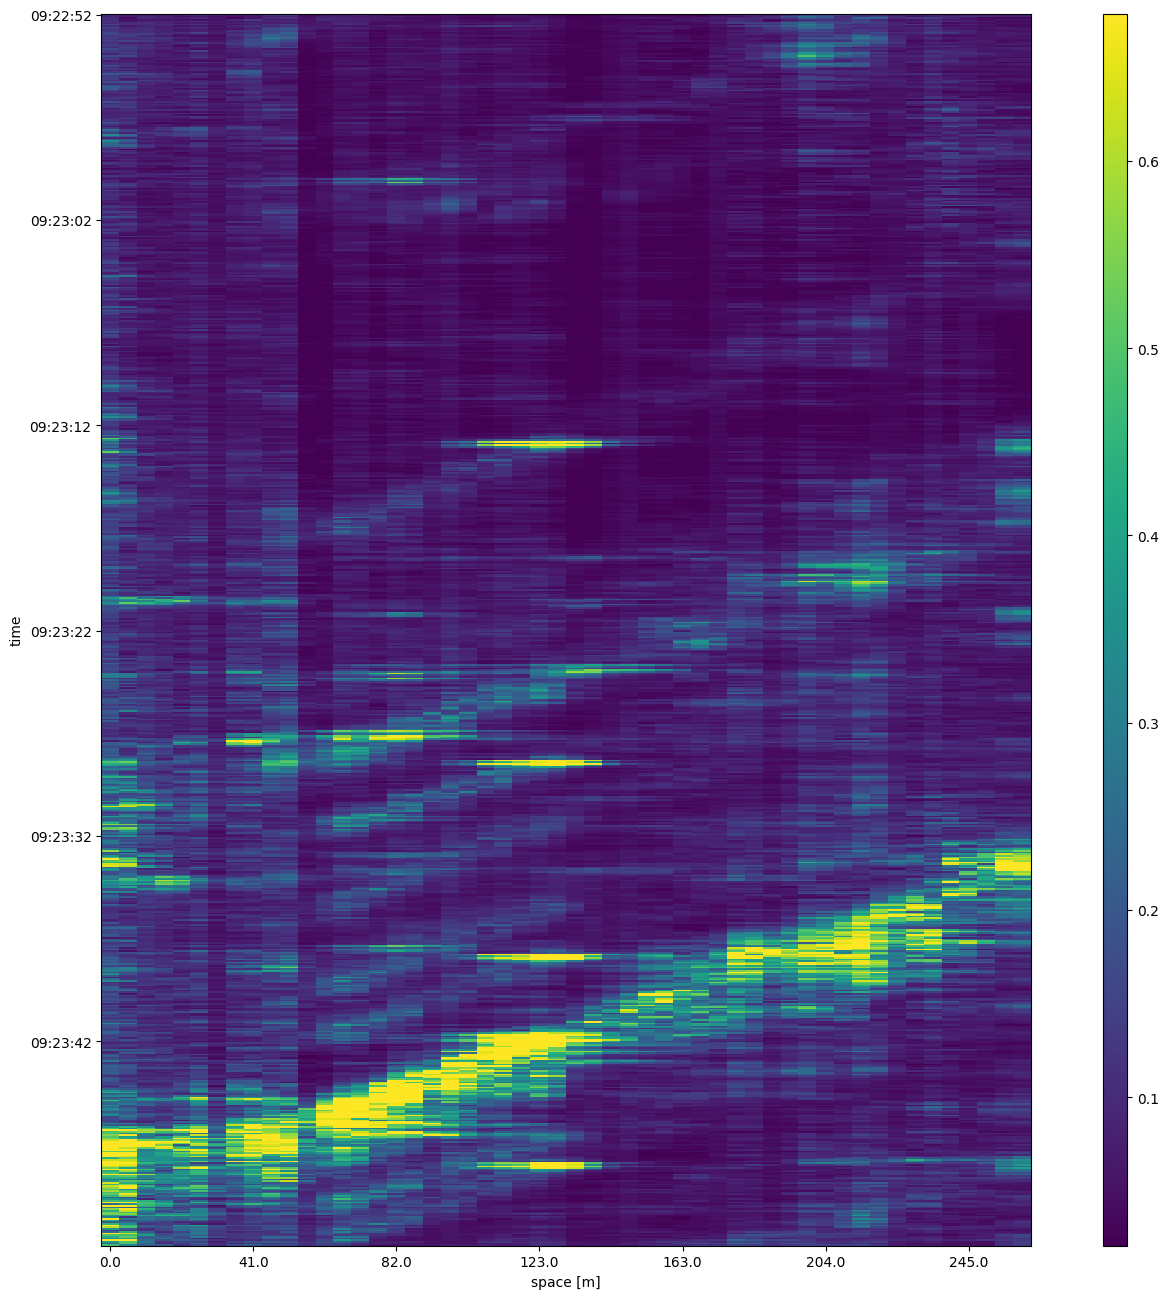

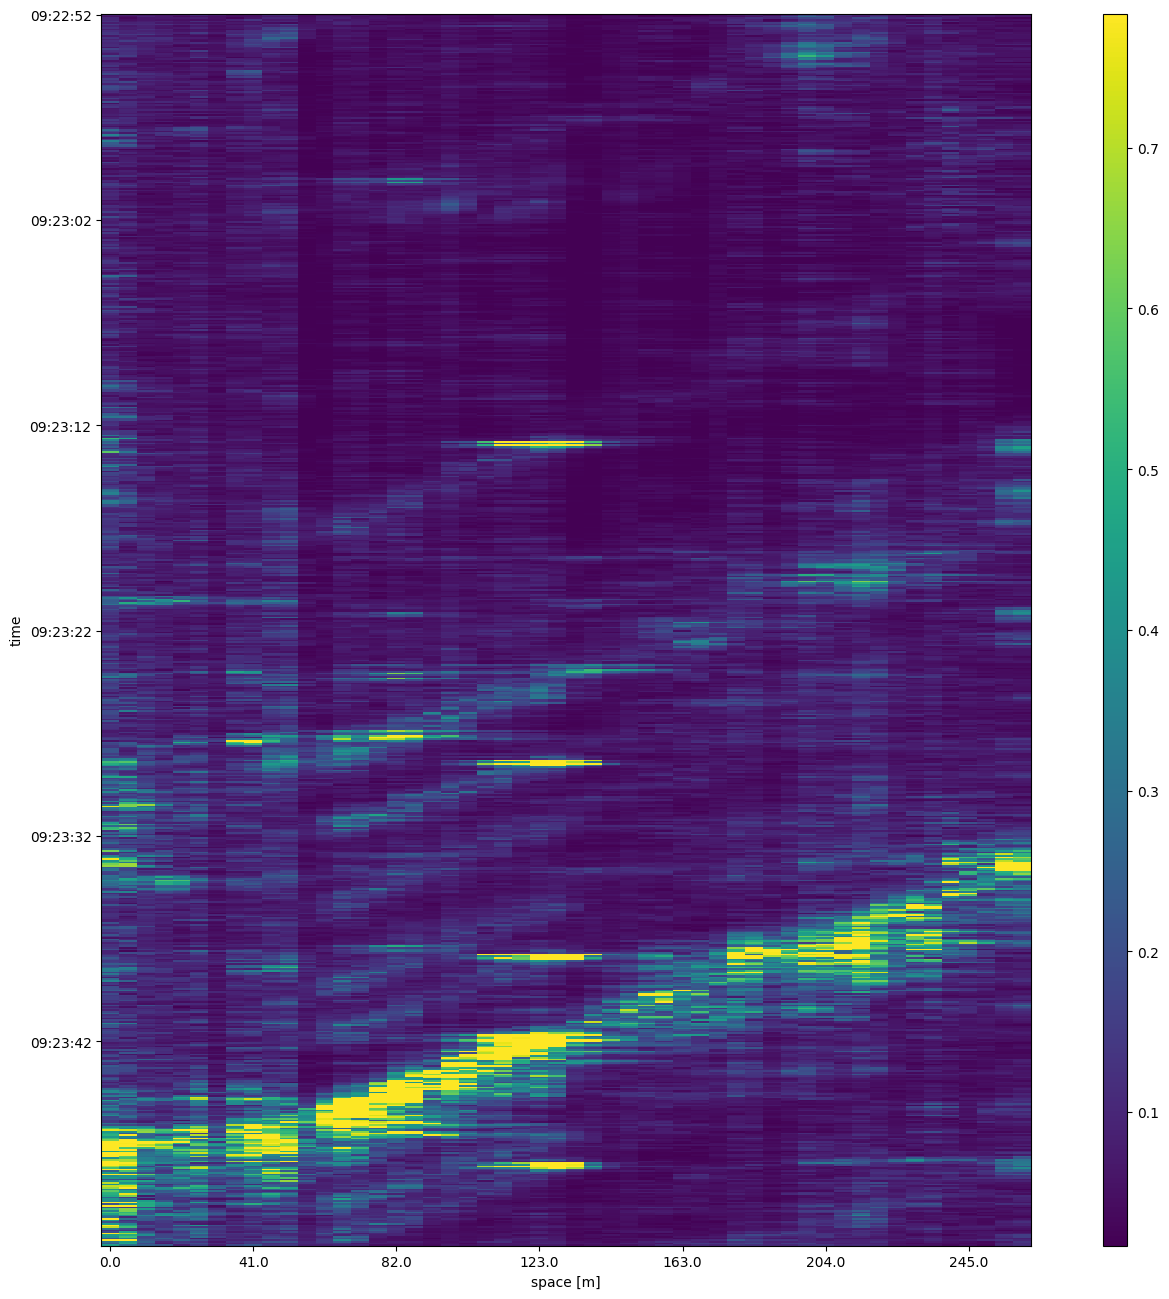

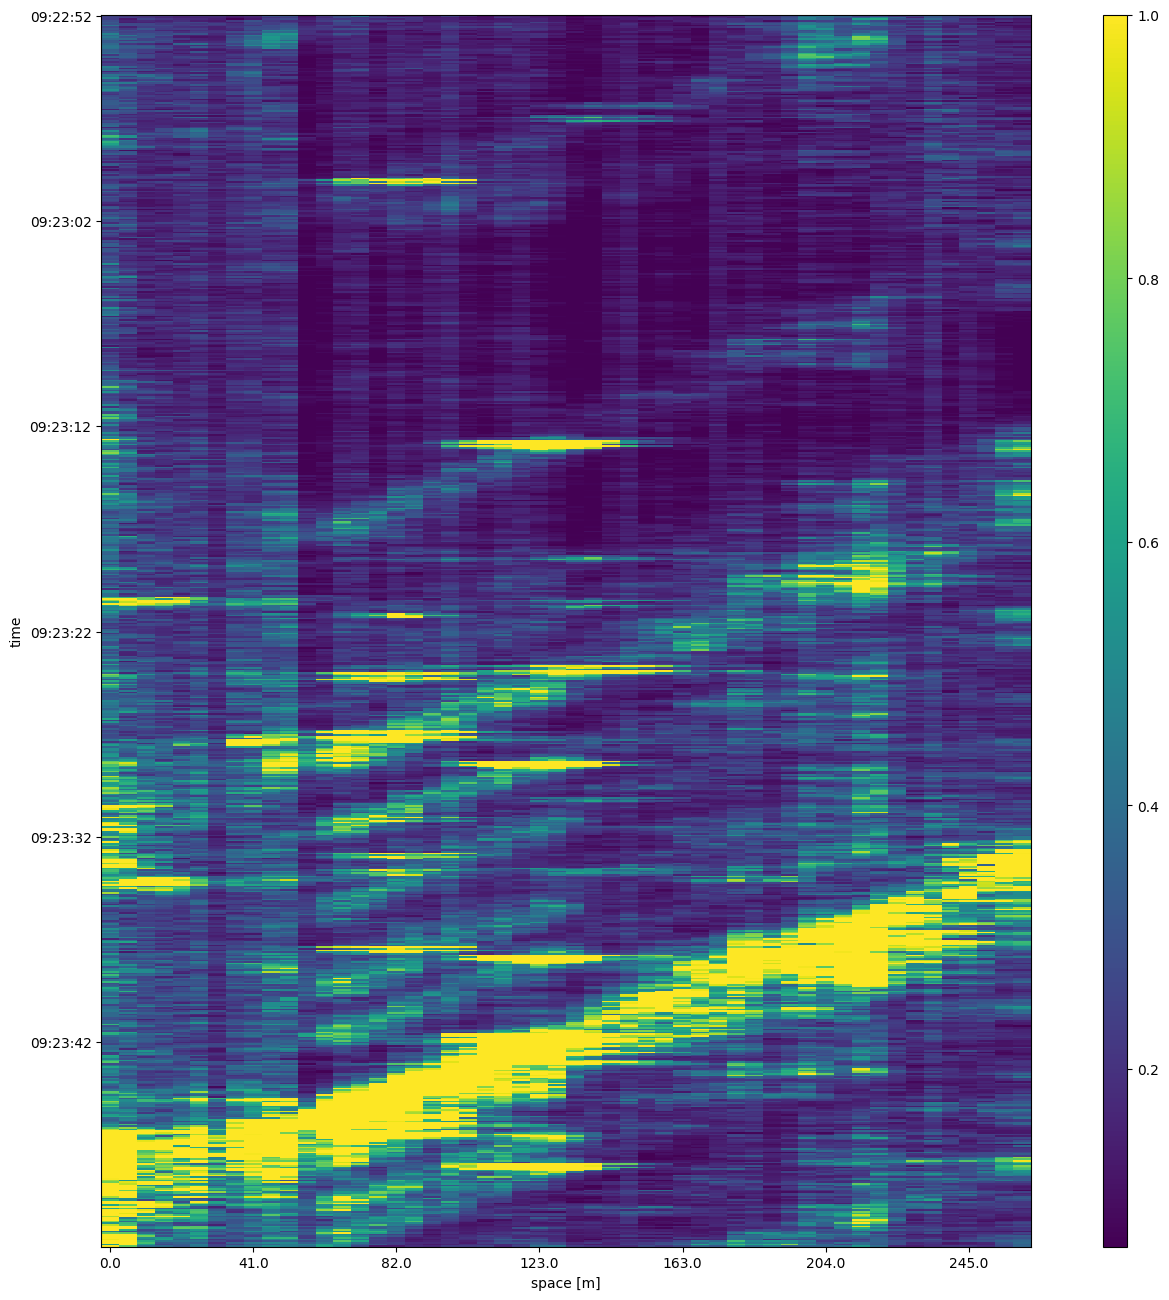

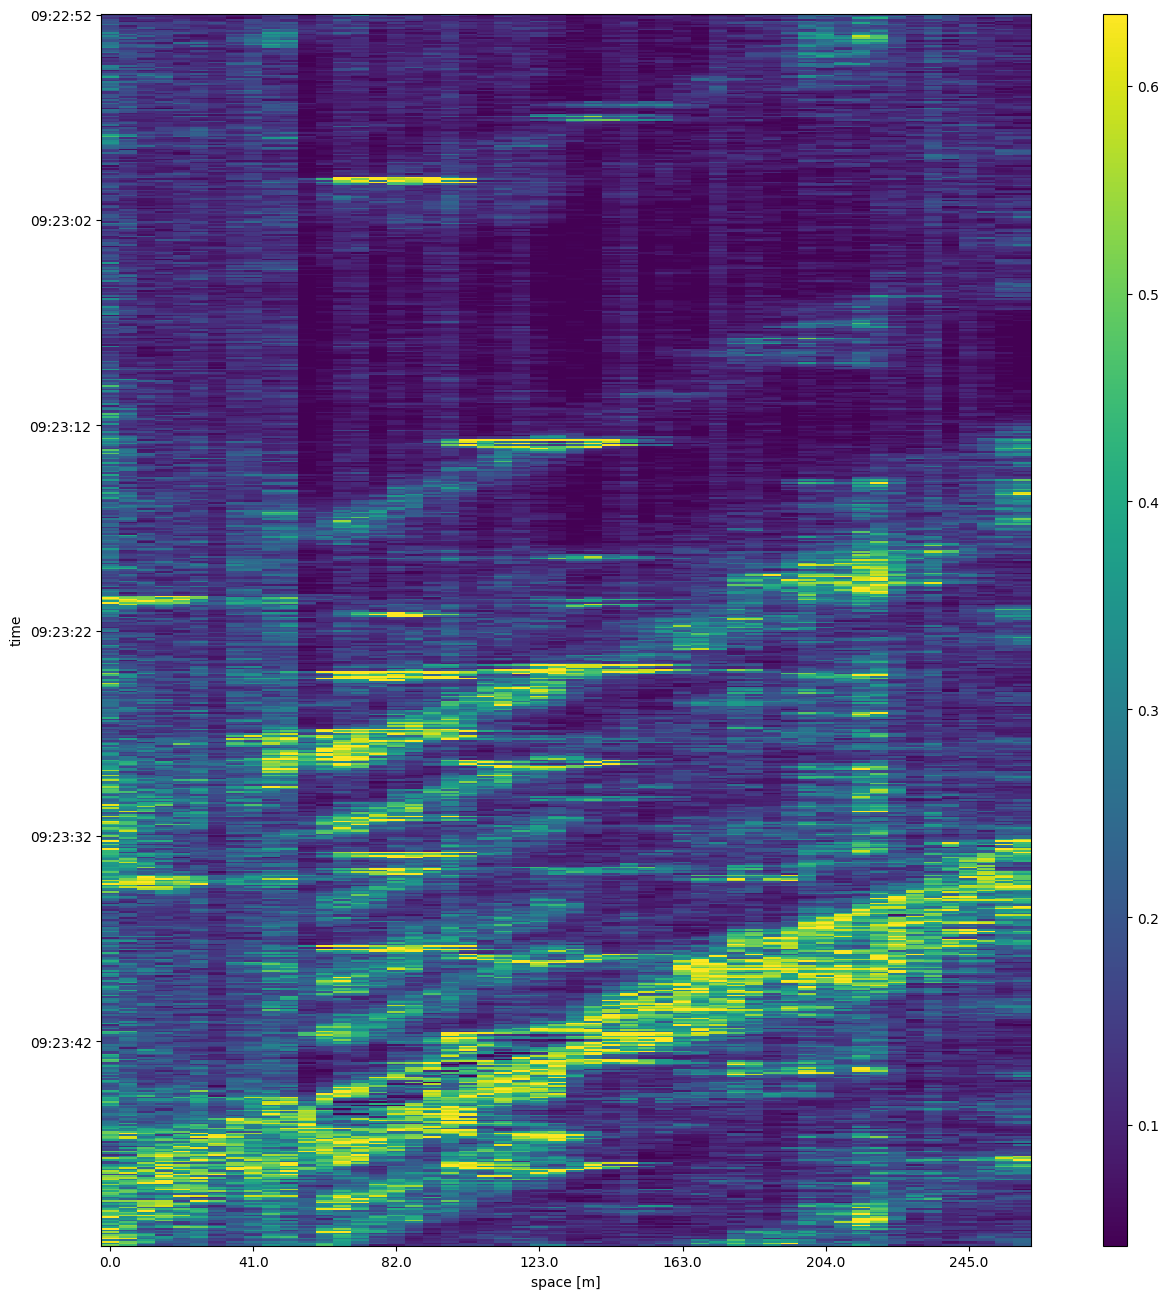

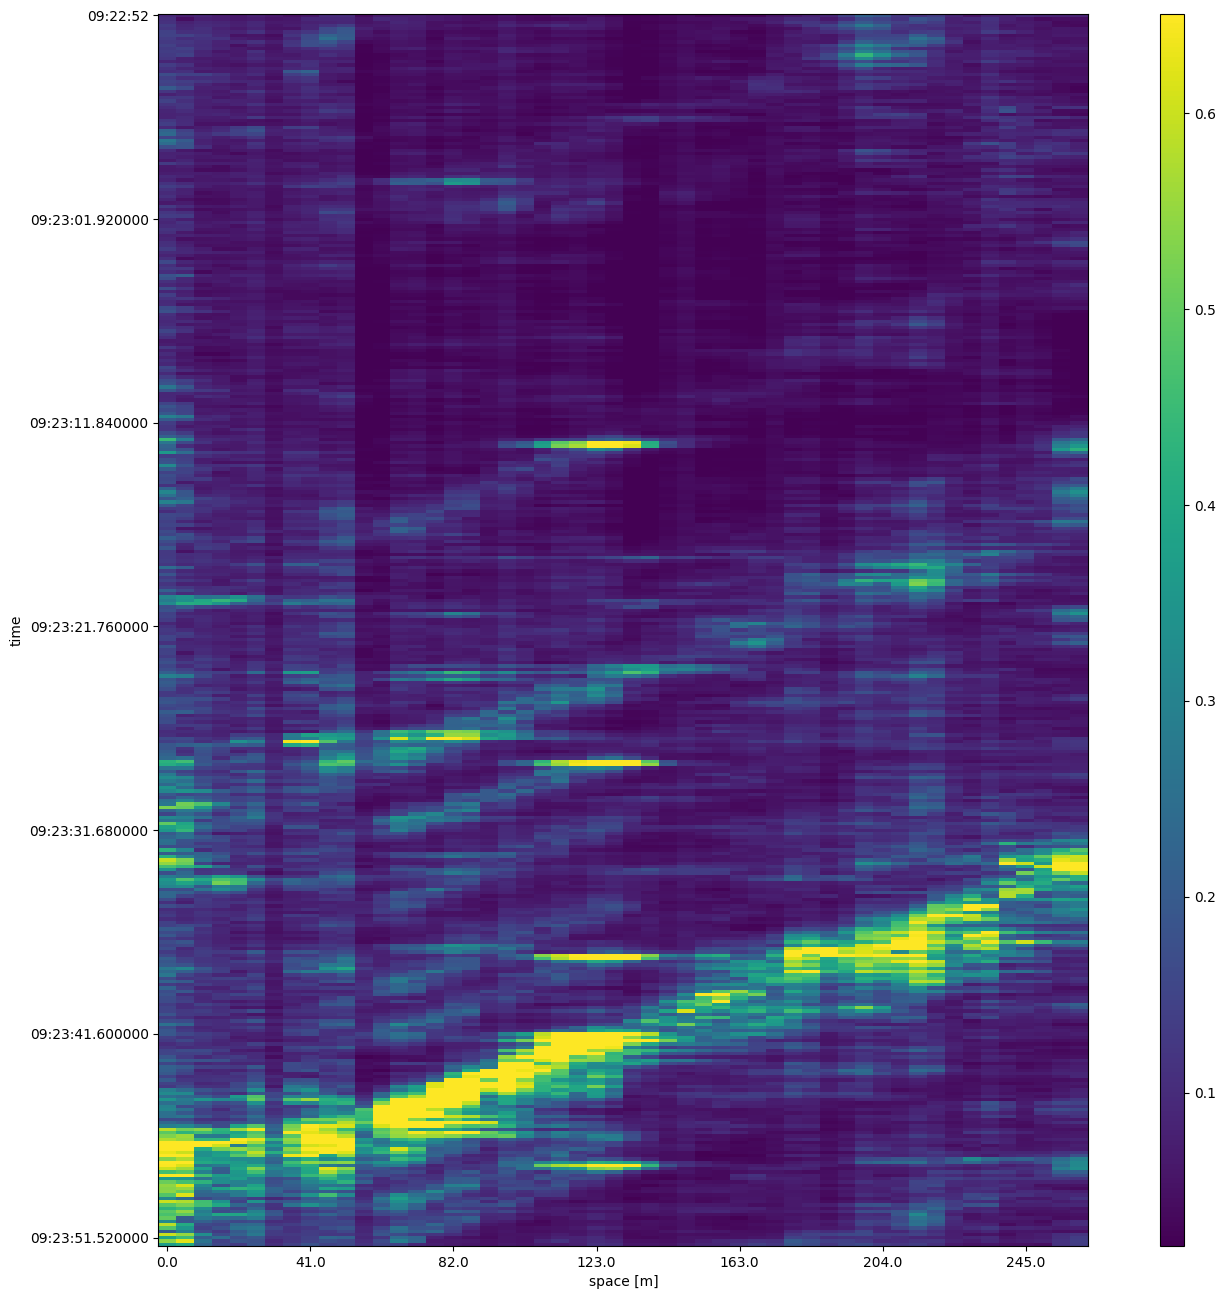

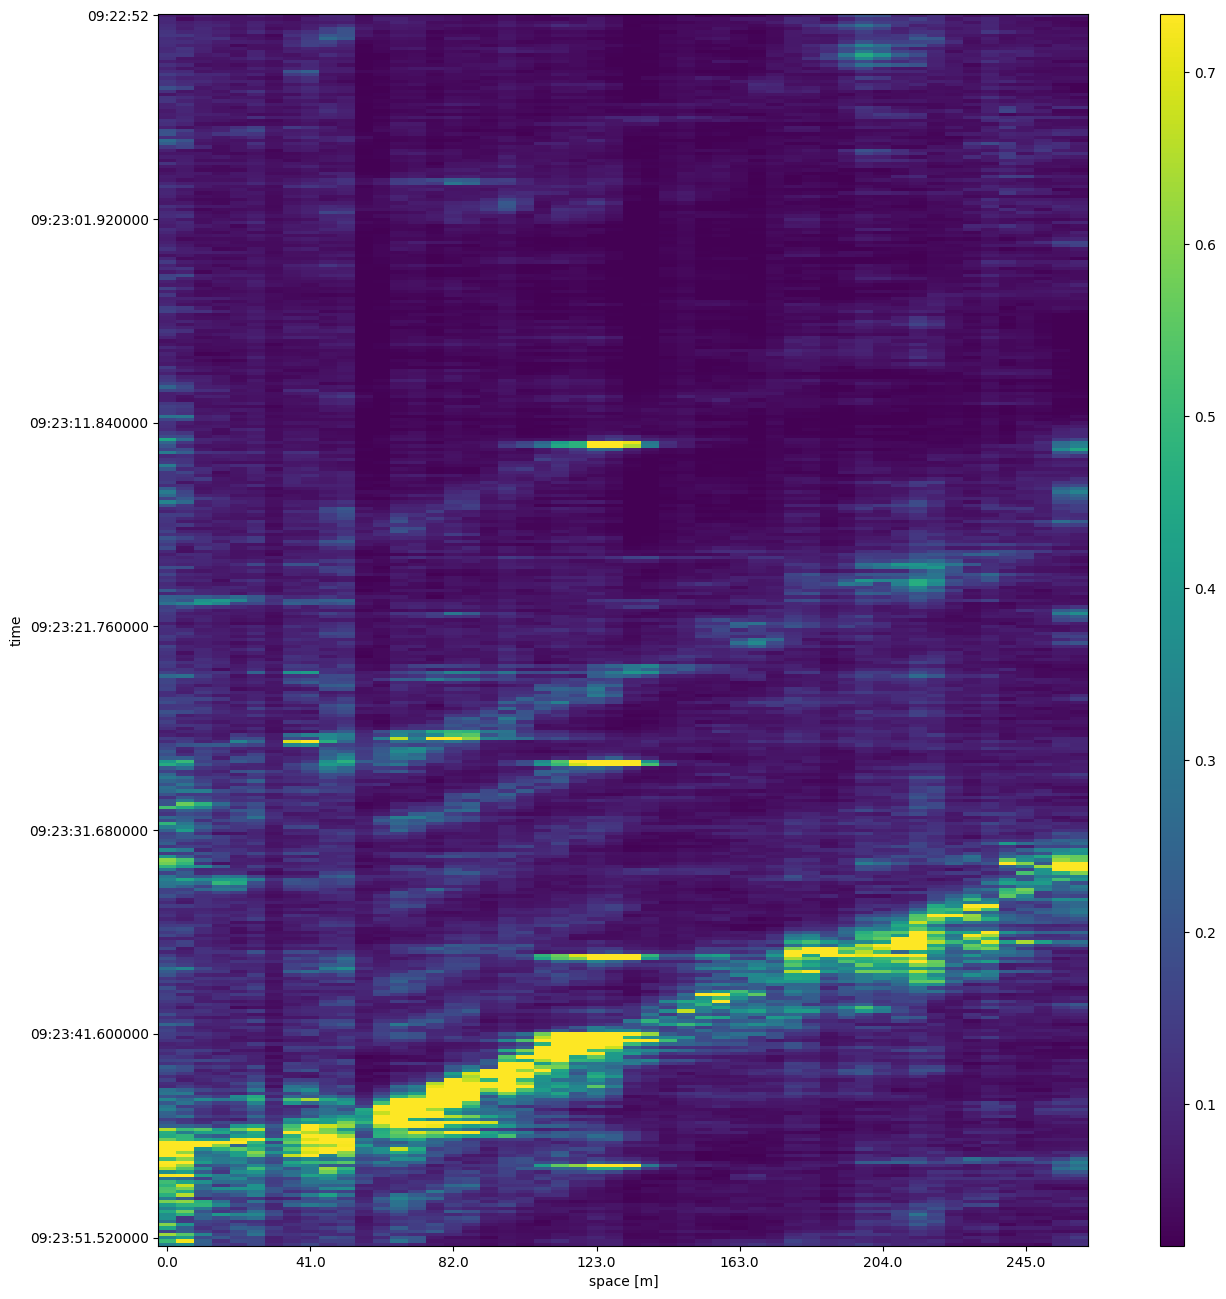

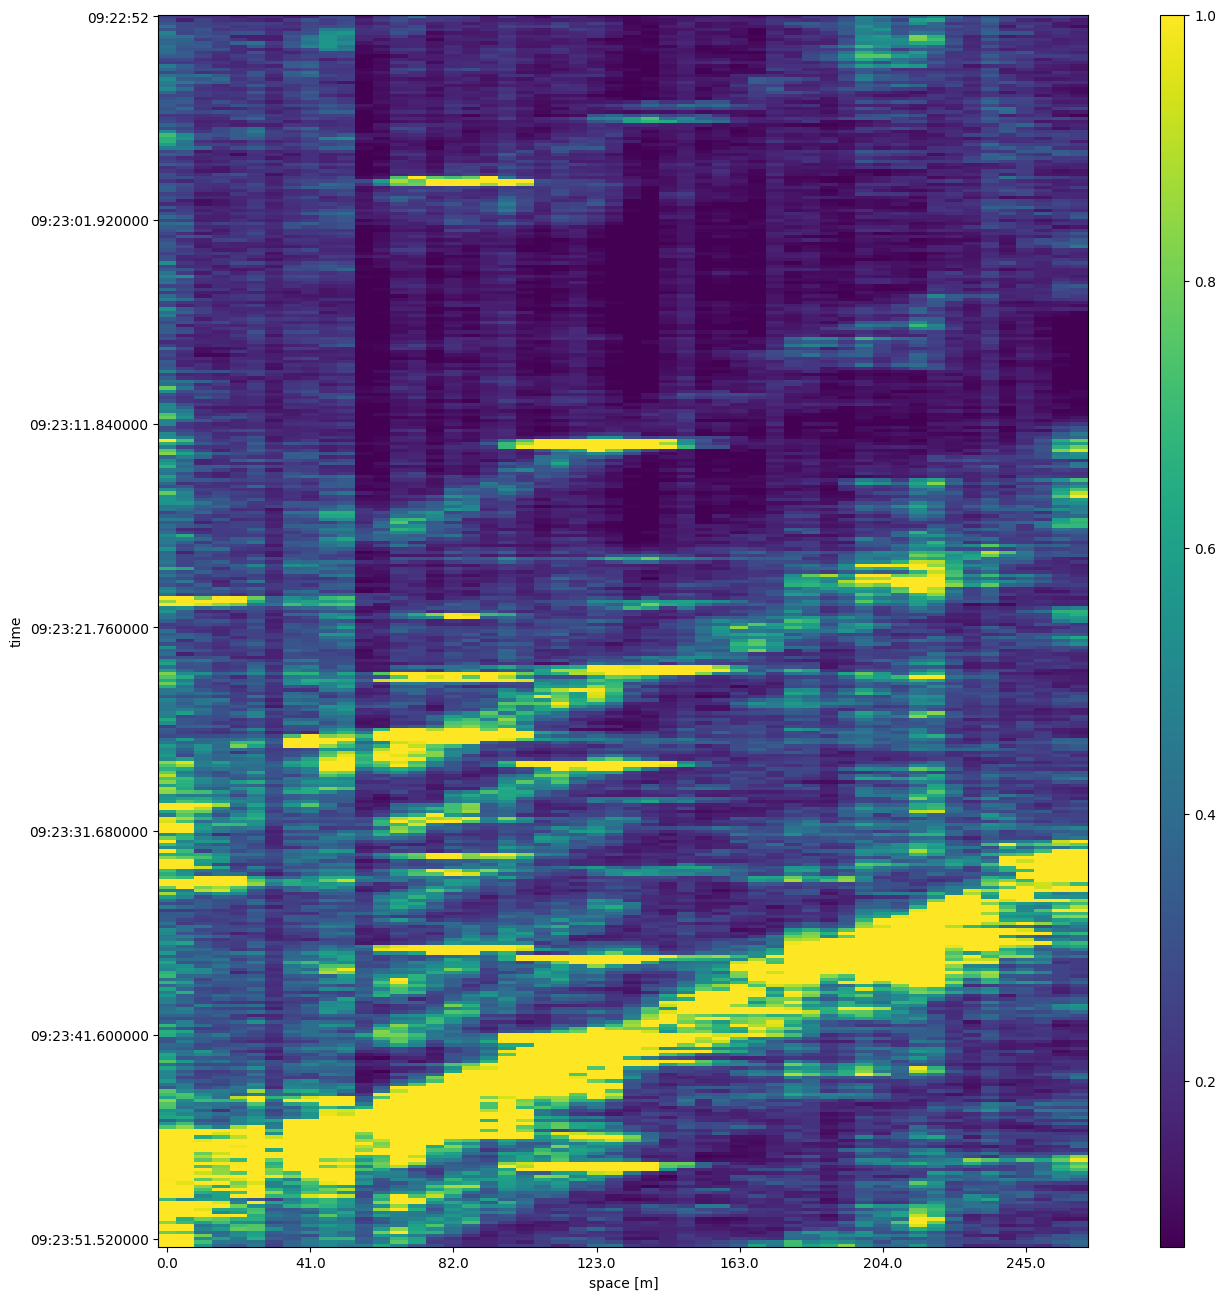

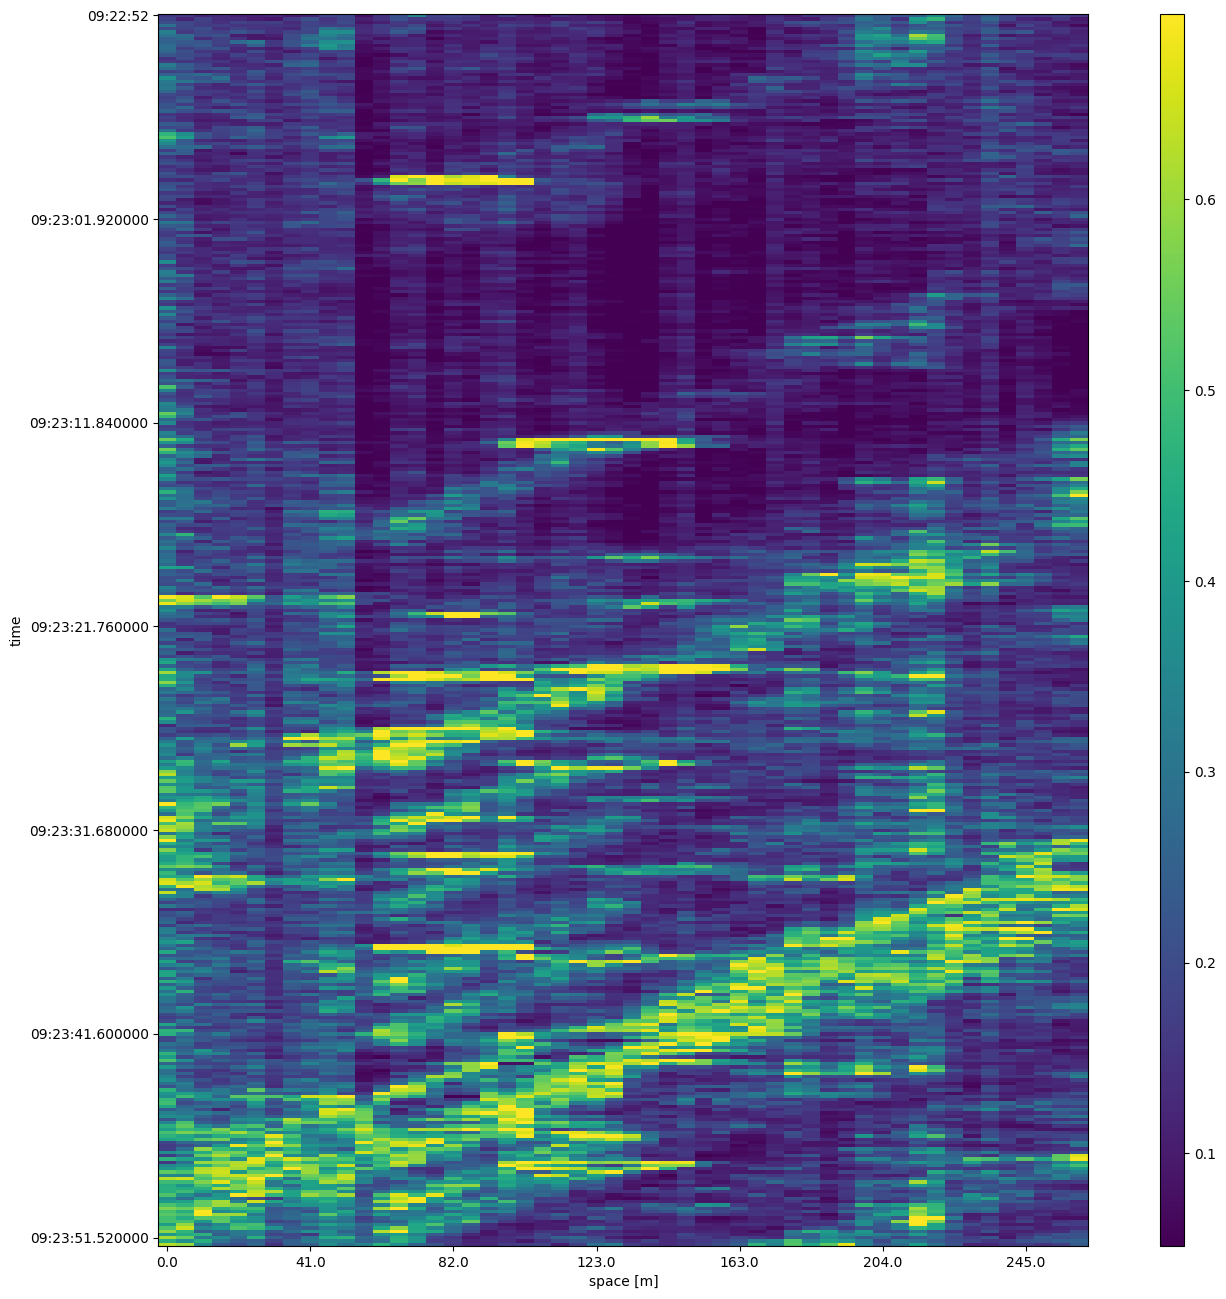

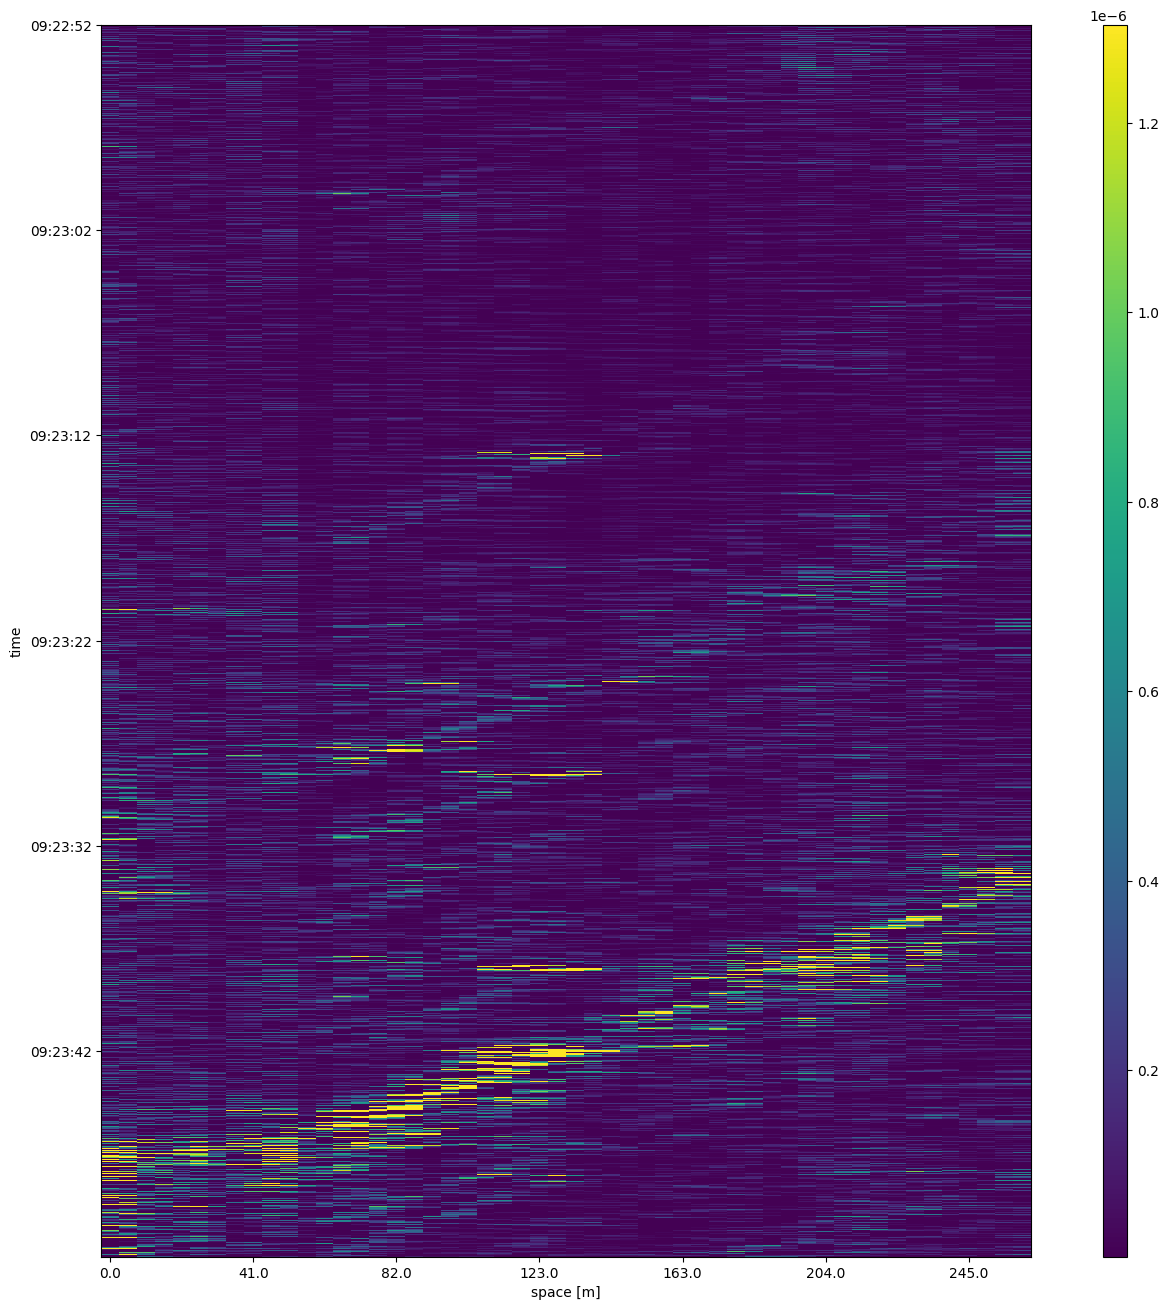

'these filters look kinda promising in compairson to the original picture'

In [269]:
data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it doesnt seem to have any great effect'''
data_1_downsampled = downsampling_time_mean(data_1_preprocessed,50,True)
plotting_function(data_1_downsampled,to_preprocess=False)


data_2_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it doesnt seem to have any great effect'''
data_2_downsampled = downsampling_time_median(data_2_preprocessed,50,True)
plotting_function(data_2_downsampled,to_preprocess=False)

data_3_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it doesnt seem to have any great effect'''
data_3_downsampled = downsampling_time_max(data_3_preprocessed,50,True)
plotting_function(data_3_downsampled,to_preprocess=False)

data_4_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it doesnt seem to have any great effect'''
data_4_downsampled = downsampling_time_max_mean(data_4_preprocessed,50,True)
plotting_function(data_4_downsampled,to_preprocess=False)




data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it doesnt seem to have any great effect'''
data_1_downsampled = downsampling_time_mean(data_1_preprocessed,100,True)
plotting_function(data_1_downsampled,to_preprocess=False)


data_2_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the median blurring taking place, however it doesnt seem to have any great effect'''
data_2_downsampled = downsampling_time_median(data_2_preprocessed,100,True)
plotting_function(data_2_downsampled,to_preprocess=False)



data_3_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it doesnt seem to have any great effect'''
data_3_downsampled = downsampling_time_max(data_3_preprocessed,100,True)
plotting_function(data_3_downsampled,to_preprocess=False)



data_4_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it doesnt seem to have any great effect'''
data_4_downsampled = downsampling_time_max_mean(data_4_preprocessed,100,True)
plotting_function(data_4_downsampled,to_preprocess=False)






''''plotting the  normal image '''
plotting_function(df_1,True)



'''these filters look kinda promising in compairson to the original picture'''

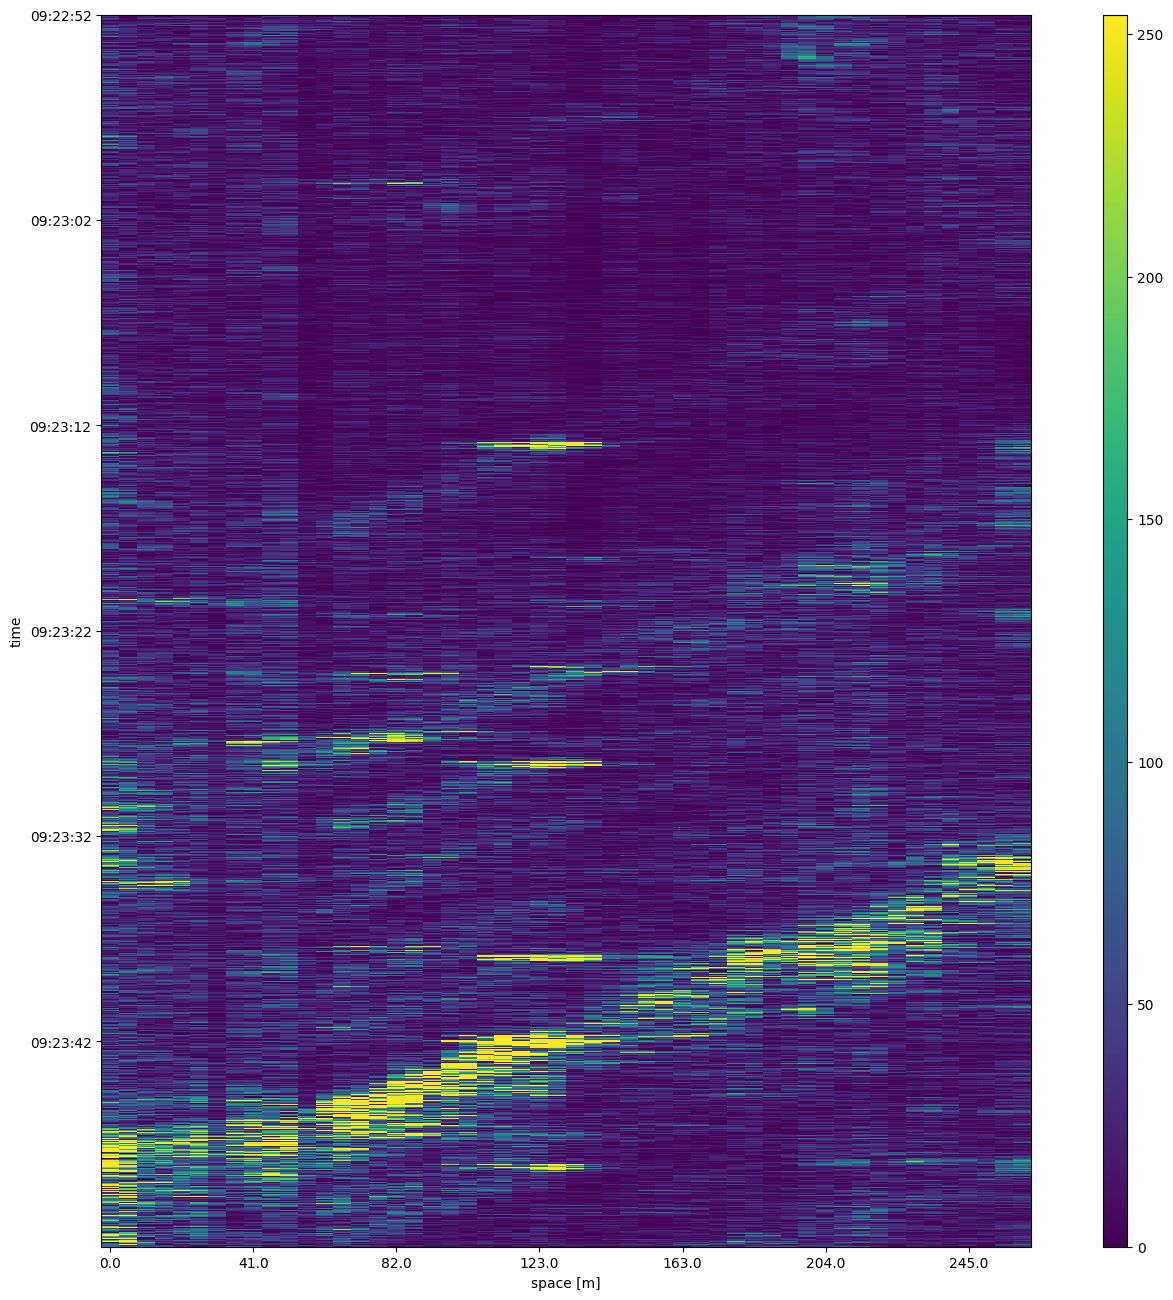

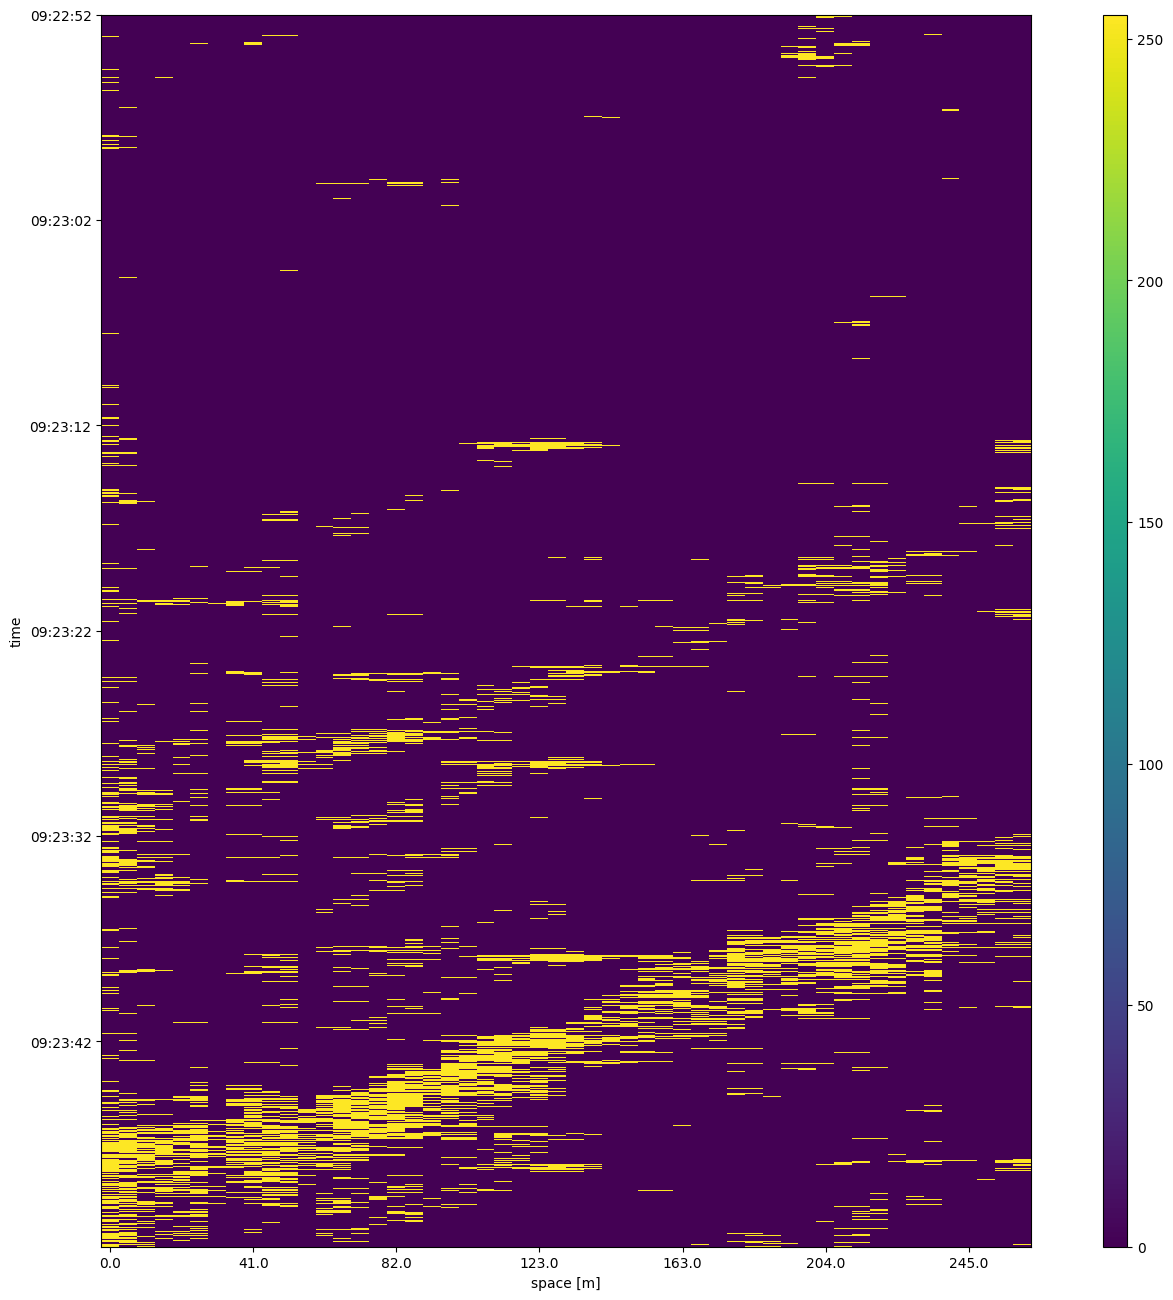

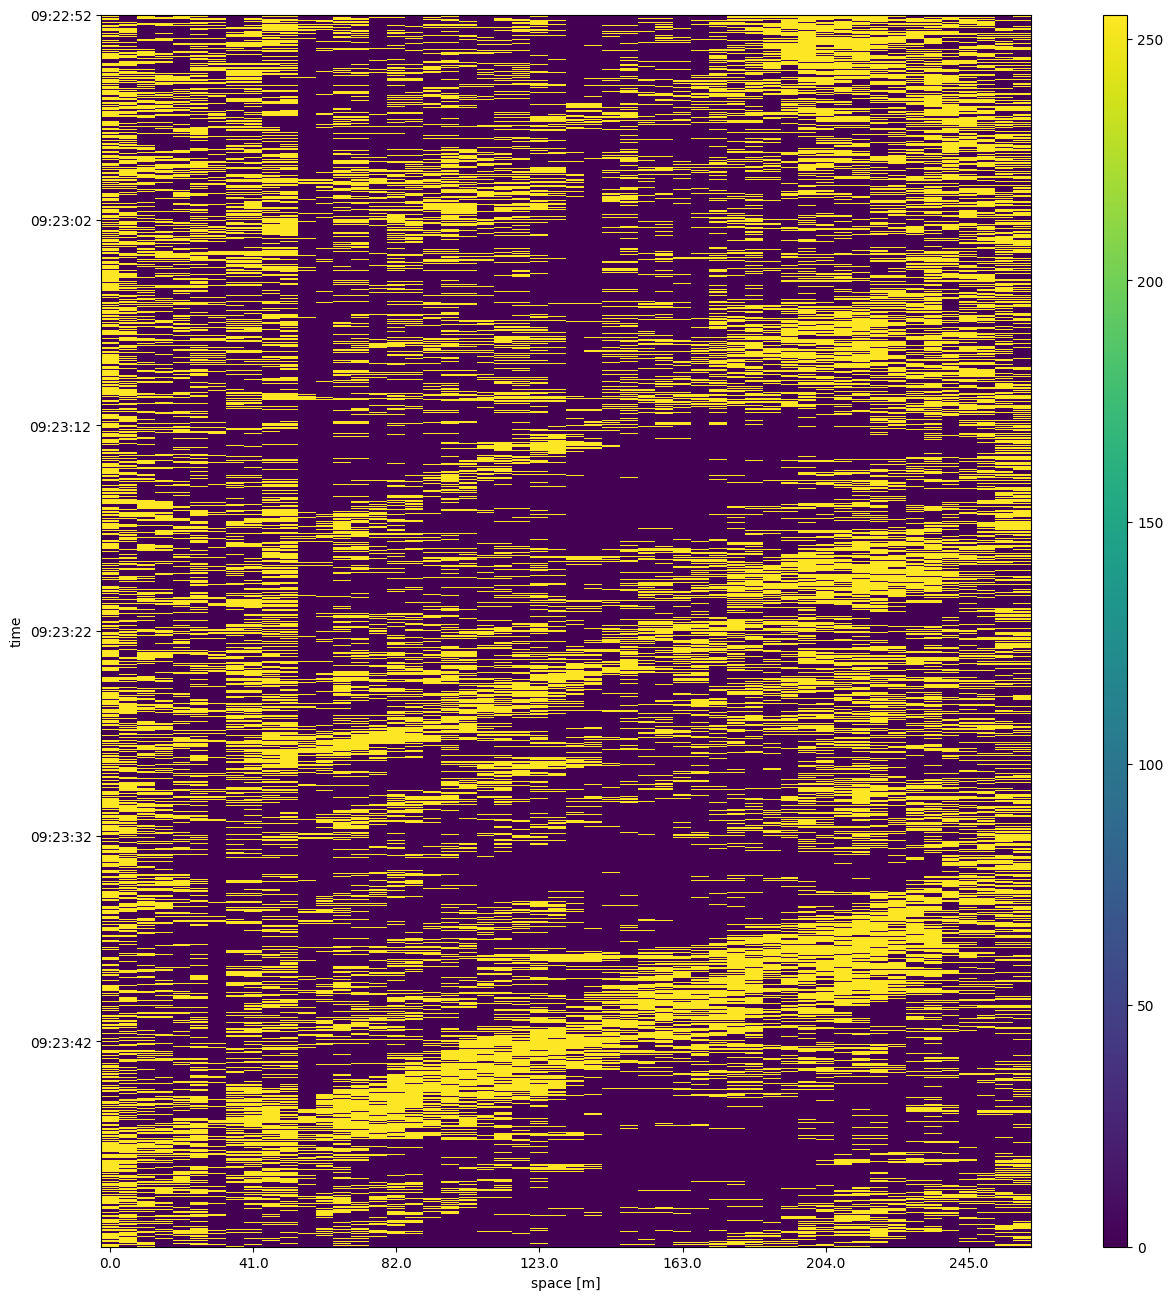

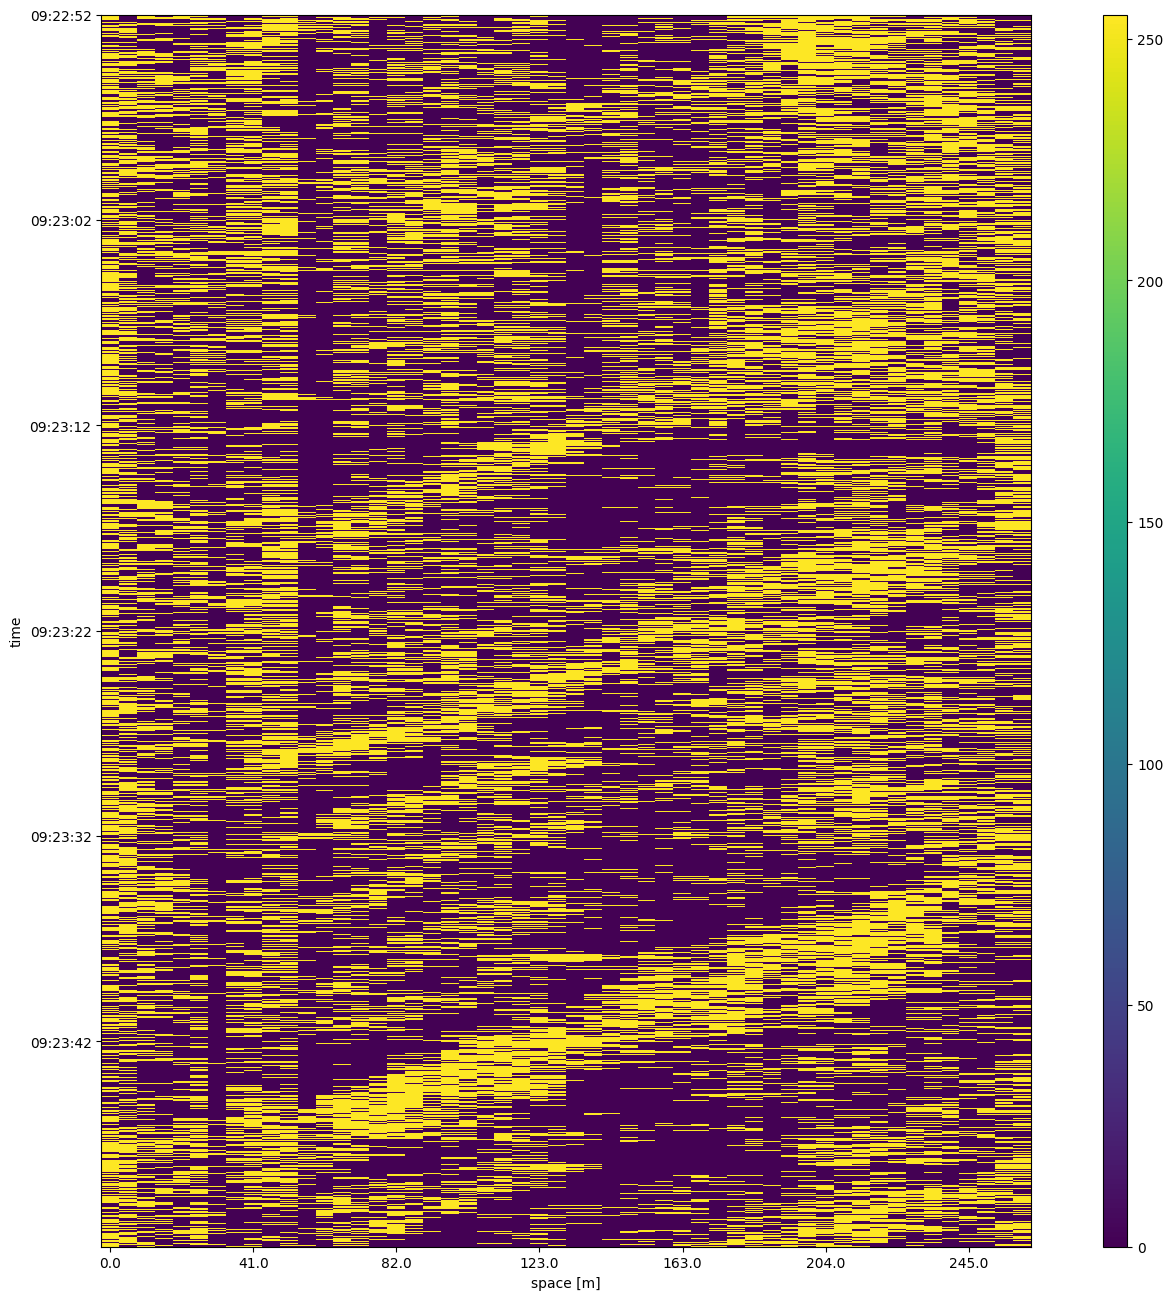

In [ ]:
'''trying converting to (0,255) scale in order to make use of some ready solutions from opencv that work on images'''

data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
data_1_converted = convert_to_img_format(data_1_preprocessed,True)
#lost some minor information probably since x =  floor(225*x)
plotting_function(data_1_converted,False)

'''trying the otsu  threshold the normal image therefore'''
data_1_thresholded = thresholding_otsu_function(data_1_converted)
'''otsu seem to have lost quite a gret deal of lines'''

plotting_function(data_1_thresholded,False)


'''adaptive thresholding on the other hand some to have produced to many positive results'''
data_2_thresholded = thresholding_adaptive_function(data_1_converted)
plotting_function(data_2_thresholded)



data_3_thresholded = thresholding_adaptive_gaussian_function(data_1_converted)
plotting_function(data_3_thresholded)






    

In [264]:
'''therefore maybe trying with tweaking the adaptive thresholding constant, to be more rigorous'''
''' commented due to lengthy output'''
# for constant in list(range(-50,-2,10)):
    
#     data_1_thresholded= thresholding_adaptive_function(data_1_converted,101,constant)
#     plotting_function(data_1_thresholded)


' commented due to lengthy output'

In [ ]:
'''therefore maybe trying with tweaking the adaptive thresholding constant, to be more rigorous'''
'''commented due to lengthy output'''
# for constant in list(range(-50,-2,10)):
#     data_2_thresholded= thresholding_adaptive_gaussian_function(data_1_converted,101,constant)
#     plotting_function(data_2_thresholded)


'''but there deosnt seem to be any difference betweene these 2 thresholding methods'''


'commented due to lengthy output'

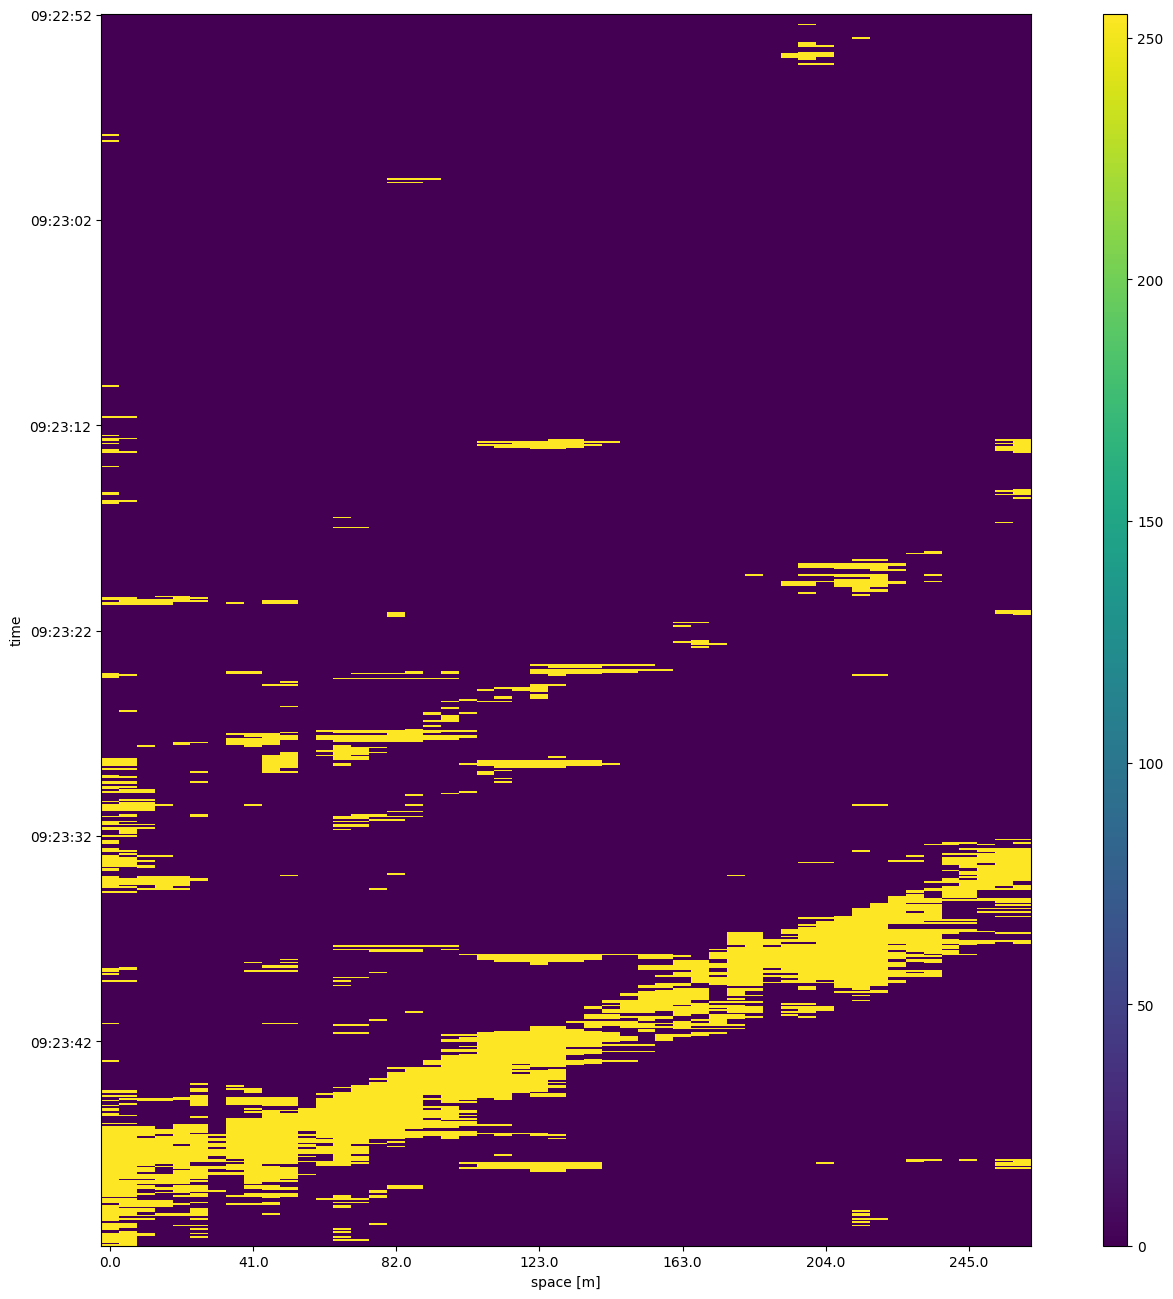

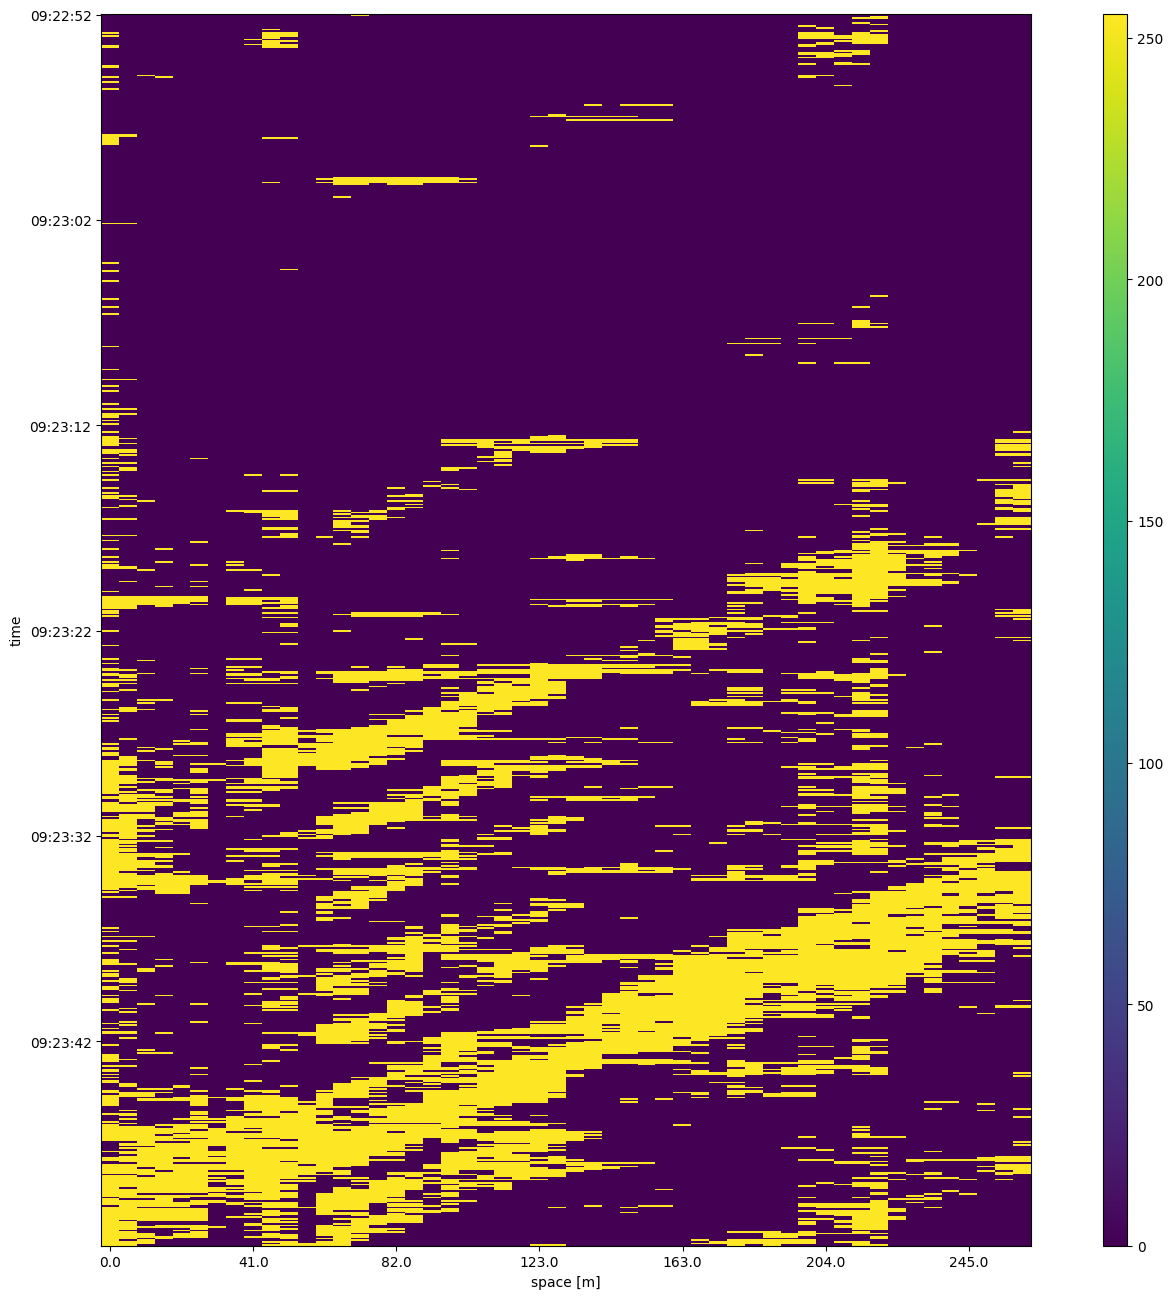

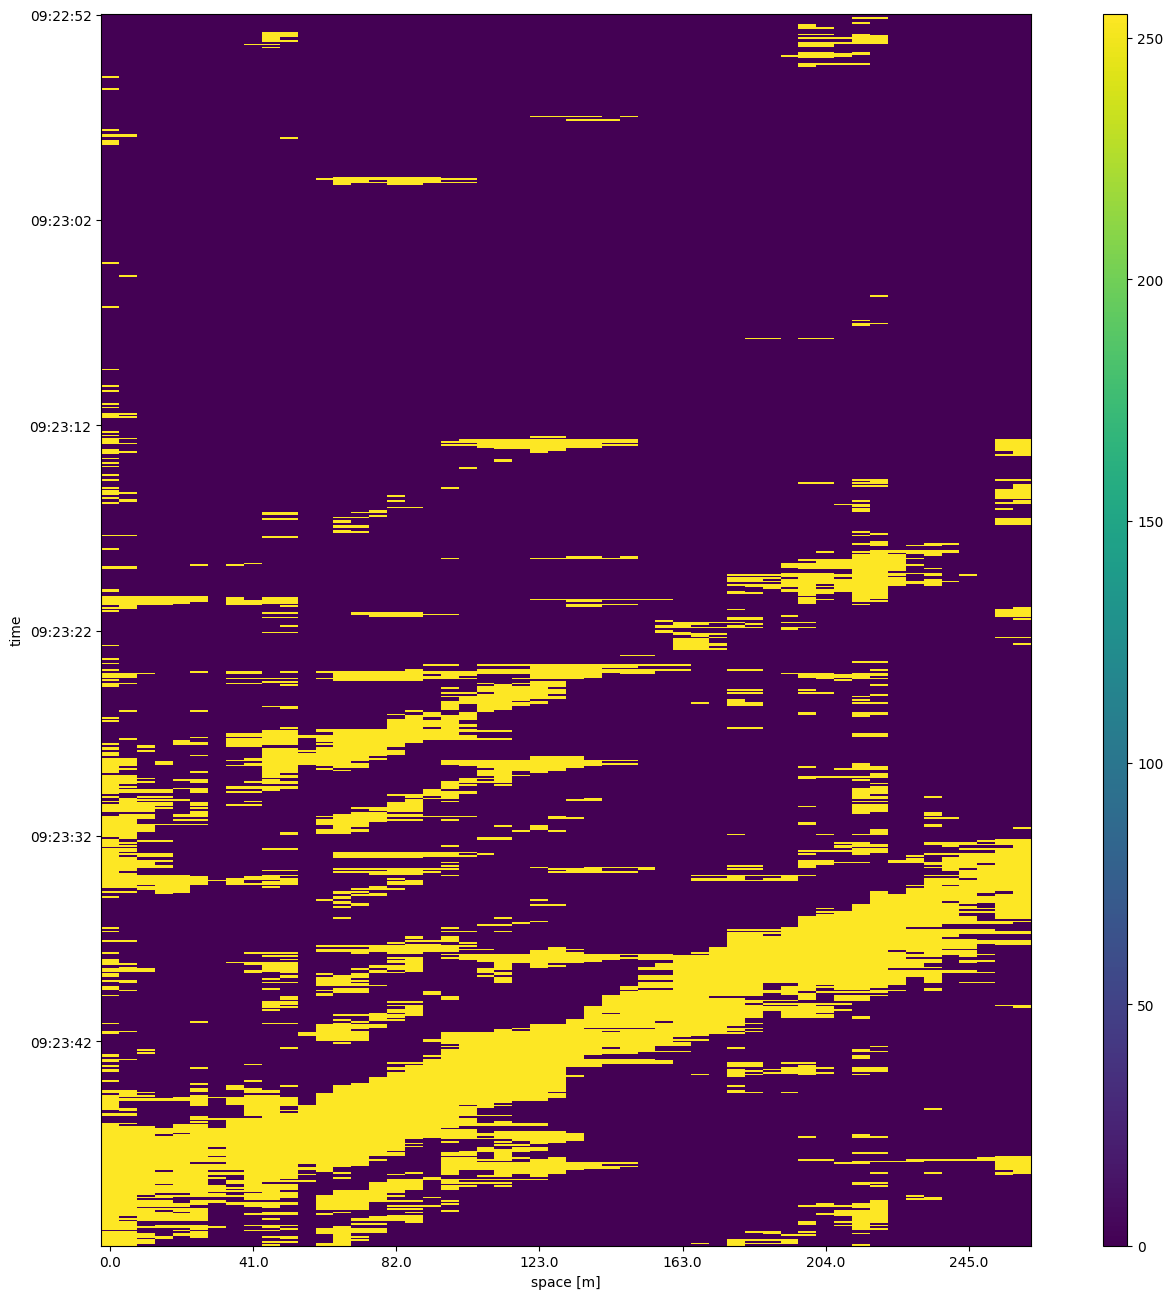

In [ ]:
'''now trying to combine the thresholding with the time downsample by aggregation'''
data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean downsampling taking place, however it doesnt seem to have any great effect'''
data_1_downsampled = downsampling_time_mean(data_1_preprocessed,50,True)
data_1_converted = convert_to_img_format(data_1_downsampled,True)

data_1_thresholded_otsu = thresholding_otsu_function(data_1_converted,True)
plotting_function(data_1_thresholded_otsu,to_preprocess=False)


'''the max_mean downsampling, seem to look much better '''
data_2_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it doesnt seem to have any great effect'''
data_2_downsampled = downsampling_time_max_mean(data_2_preprocessed,50,True)
data_2_converted = convert_to_img_format(data_2_downsampled,True)

data_2_thresholded_otsu = thresholding_otsu_function(data_2_converted,True)
plotting_function(data_2_thresholded_otsu,to_preprocess=False)



'''the max downsampling, seem to be worse than the max_mean '''
data_3_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the mean blurring taking place, however it doesnt seem to have any great effect'''
data_3_downsampled = downsampling_time_max(data_3_preprocessed,50,True)
data_3_converted = convert_to_img_format(data_3_downsampled,True)

data_3_thresholded_otsu = thresholding_otsu_function(data_3_converted,True)
plotting_function(data_3_thresholded_otsu,to_preprocess=False)






In [276]:
'''now trying combining the best looking downsampling with the adsaptive threshold binarization, but doesnt seem to good'''
# for constant in list(range(-50,-2,10)):
    
#      data_2_thresholded_adaptive = thresholding_adaptive_function(data_2_converted,101,constant,True)
#      plotting_function(data_2_thresholded_adaptive,to_preprocess=False)




'now trying combining the best looking downsampling with the adsaptive threshold binarization, but doesnt seem to good'

<class 'pandas.core.frame.DataFrame'>


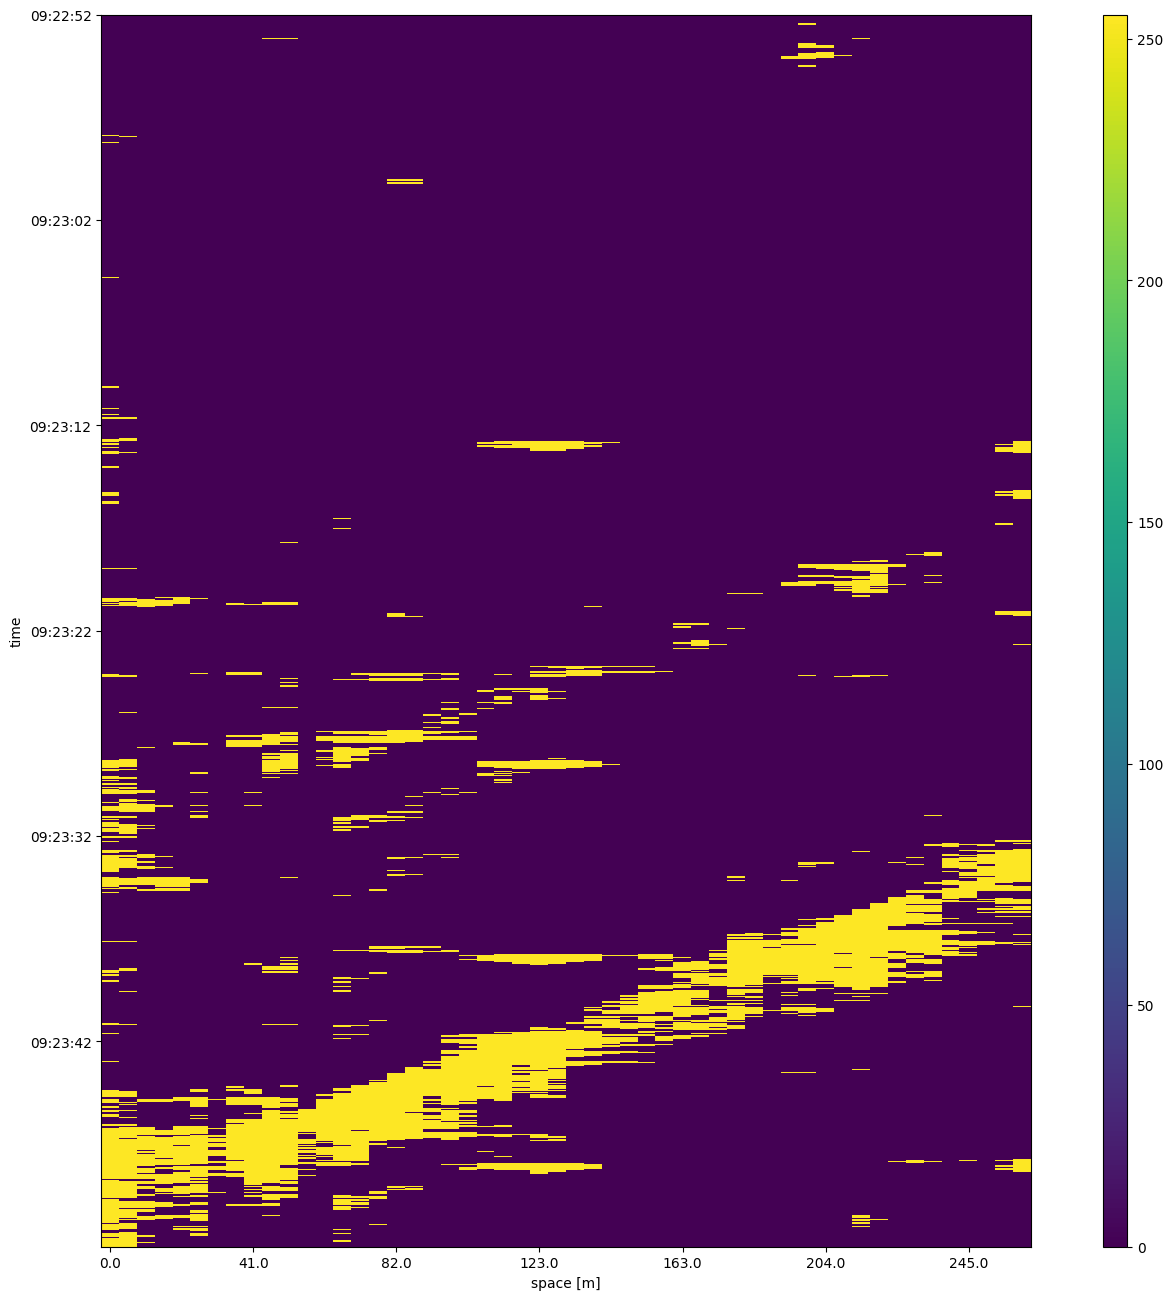

In [ ]:
'''now instead of downsampling , the mean fo vertical neighbourhood for  each pixel in the retained original image size. not looking too good'''

data_1_preprocessed = basic_preprocessing(df_1,True,ret_dataframe=True)
'''the vertical mean blurring taking place,cobined with converting to 0-255 and thresholding otsu'''
data_1_blurred = blurring_function(data_1_preprocessed,(50,1),False,True)


data_1_converted = convert_to_img_format(data_1_blurred,True)

data_1_thresholded_otsu = thresholding_otsu_function(data_1_converted,True)
plotting_function(data_1_thresholded_otsu,to_preprocess=False)

#plotting_function(data_2_blurred,to_preprocess=False)


In [277]:
''''and adaptive thresholding for this mean aggregation again doesnt look that good '''
# for constant in list(range(-50,-2,10)):
    
#      data_1_thresholded_adaptive = thresholding_adaptive_function(data_1_converted,101,constant,True)
#      plotting_function(data_1_thresholded_adaptive,to_preprocess=False)

"'and adaptive thresholding for this mean aggregation again doesnt look that good "